<a href="https://colab.research.google.com/github/KulkarniHrishikesh/PyDMD/blob/master/DMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Examples of Koopman embeddings: Nonlinear system with single fixed point and a slow manifold

Here, we consider an example system with a single fixed point, given by:

$$
\dot{x}_1 = \mu x_1
\tag{1}
$$

$$
\dot{x}_2 = \lambda (x_2 - x_1^2)
\tag{2}
$$

For $(\lambda < \mu < 0)$, the system exhibits a slow attracting manifold given by $(x_2 = x_1^2)$. It is possible to augment the state \(x) with the nonlinear measurement $(g = x_1^2)$, to define a three-dimensional Koopman invariant subspace. In these coordinates, the dynamics become linear:

$$
\frac{d}{dt}
\begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix} =
\begin{bmatrix}
\mu & 0 & 0 \\
0 & \lambda & -\lambda \\
0 & 0 & 2\mu
\end{bmatrix}
\begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix}
$$

where

$$
\begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix} =
\begin{bmatrix}
x_1 \\
x_2 \\
x_1^2
\end{bmatrix}
\tag{3}
$$

The full three-dimensional Koopman observable vector space is visualized in **Fig. 2**. Trajectories that start on the invariant manifold $(y_3 = y_1^2)$, visualized by the blue surface, are constrained to stay on this manifold. There is a slow subspace, spanned by the eigenvectors corresponding to the slow eigenvalues $(\mu)$ and $(2\mu)$; this subspace is visualized by the green surface.

Finally, there is the original asymptotically attracting manifold of the original system, $(y_2 = y_1^2)$, which is visualized as the red surface. The blue and red parabolic surfaces always intersect in a parabola that is inclined at a 45° angle in the $(y_2)-(y_3)$ direction. The green surface approaches this 45° inclination as the ratio of fast to slow dynamics becomes increasingly large. In the full three-dimensional Koopman observable space, the dynamics produce a single stable node, with trajectories rapidly attracting onto the green subspace and then slowly approaching the fixed point.



In [1]:
# Import libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
!pip install plotly

In [ ]:
# Define ODE system with parameters (mu and lam here)
def ode(x, t):
    return [
        mu * x[0],
        lam * (x[1] - x[0] ** 2)
    ]

In [ ]:
# Parameter values, Initial conditions, T domain
mu = -1
lam = -10
x_initial = [6, 36]
t_domain = [0, 2]

# Generate T data with Delta T
dt = 0.001
t_data = np.arange(t_domain[0], t_domain[1], dt)

In [ ]:
Variable_names = ["x1", "x2"]
X = odeint(ode, x_initial, t_data)

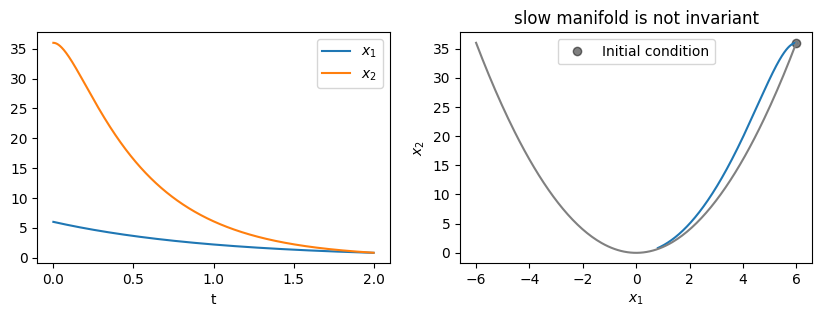

In [ ]:
# Plot 2D
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(t_data, X[:, 0], label='$x_1$')
axs[0].plot(t_data, X[:, 1], label='$x_2$')
axs[0].set(xlabel='t')
axs[0].legend()

axs[1].plot(X[0, 0], X[0, 1], 'o', color='black', label="Initial condition", alpha=0.5)
axs[1].plot(X[:, 0], X[:, 1])
x1g = np.linspace(-6, 6, 200)
x2slow = x1g*x1g
axs[1].plot(x1g, x2slow, 'grey')
axs[1].set(xlabel='$x_1$', ylabel='$x_2$')
axs[1].set_title('slow manifold is not invariant')
axs[1].legend();

# Algorithm 1: Standard Dynamic Mode Decomposition (DMD)

1. **Arrange the Data:**
   - Arrange the data ${z_0, \ldots, z_m}$ with $z_i \in \mathbb{R}^n$ into matrices \(X\) and \(Y\):

     X = \begin{bmatrix}
     z_0 & z_1 & \cdots & z_{m-1}
     \end{bmatrix}

     Y = \begin{bmatrix}
     z_1 & z_2 & \cdots & z_m
     \end{bmatrix}

     So, $X$ is $n \times m$ and so is $Y$ and for these examples, we have $n < m$. (In fluid dynamics examples in practice, I guess $n > m$, right??)


2. **Compute the (Reduced) SVD of \(X\):**
   - Compute the Singular Value Decomposition (SVD) of \(X\):
     $$
     X = U \Sigma V^*
     $$
     where:
     - U is an $n \times r$ matrix, with columns of $U$ being eigenvectors of $X X^t$
     - $\Sigma$ is a diagonal r*r matrix,
     - V is an m*r matrix, with columns of $V$ being eigenvectors of $X^t X$,
     - r is the rank of X. Here, $r = n$ for the case $n < m$.

3. **Define the Matrix $\widetilde{A}$:**
   - Define the $r \times r$ matrix $\widetilde{A}$ as:
   $$
   \widetilde{A} = U^* Y V \Sigma^{-1}
   $$
   
   So in the example below, $\tilde{A}$ is $n \times n$ matrix.

4. **Compute Eigenvalues and Eigenvectors of $\tilde{A}$:**
   - Compute the eigenvalues $\lambda$ and eigenvectors w of $\tilde{A}$:
     
     $$
     \tilde{A} w = \lambda w
     $$

5. **Compute the DMD Mode:**
   - The DMD mode $\hat{\phi}$ corresponding to the DMD eigenvalue $\lambda$ (discrete time) or the continuous time eigenvalue $\log(\lambda) / \Delta t$ is given by:
     
     $$
     \hat{\phi} = U w
     $$

6. **Reconstruction:**
  - ??? TBD ???


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig, expm
from scipy.linalg import logm

def dynamic_mode_decomposition(X, Y, r=None, delta_t=None):
    """
    Dynamic Mode Decomposition (DMD) Algorithm with proper mode truncation.

    Parameters:
    X (numpy.ndarray): Matrix of snapshot data (columns are snapshots at different times).
    Y (numpy.ndarray): Matrix of snapshot data (columns are snapshots at different times, shifted by one time step).
    r (int): The number of modes to retain. If None, all modes are used.

    Returns:
    Phi (numpy.ndarray): DMD modes.
    Lambda (numpy.ndarray): DMD eigenvalues.
    omega (numpy.ndarray): DMD frequencies.
    """

    # Ensure X1 and X2 have the same number of rows
    assert X.shape[0] == Y.shape[0], "X and Y must have the same number of rows"

    # Singular Value Decomposition
    U, Sigma, Vh = svd(X, full_matrices=False)

    # Determine rank to use
    if r is not None:
        r = min(r, U.shape[1])
        U = U[:, :r]
        Sigma = Sigma[:r]
        Vh = Vh[:r, :]

    # Avoid division by zero by replacing zero singular values with a small number
    tol = 1e-10
    Sigma_inv = np.array([1/s if s > tol else 0 for s in Sigma])
    #print(Sigma_inv)
    Sigma_inv = np.diag(Sigma_inv)

    # Compute Atilde
    Atilde = U.T @ Y @ Vh.T @ Sigma_inv

    # Eigen decomposition of Atilde
    Lambda, w = eig(Atilde)

    # Compute DMD modes
    #Phi = Y @ Vh.T @ Sigma_inv @ Lambda
    Phi = U @ w

    # Compute frequencies safely
    omega = np.zeros_like(Lambda, dtype=complex)
    for i, lam in enumerate(Lambda):
        if np.abs(lam) > tol:
            # Compute the logarithm and avoid division by zero
            log_lambda = np.log(lam)
            max_imag_log = np.max(np.abs(np.imag(log_lambda)))
            if max_imag_log > tol:
                omega[i] = log_lambda / max_imag_log * 2 * np.pi
            else:
                omega[i] = np.nan  # Assign NaN if max imaginary log is too small
        else:
            omega[i] = np.nan  # Assign NaN if eigenvalue is too small

    # Optionally, apply delta_t to interpret the dynamics
    # Compute the matrix exponential of A_tilde * delta_t
    #A_dmd = expm(Atilde * delta_t)
    #eigenvalues_dmd = np.diag(logm(A_dmd)) / delta_t

    return Phi, Lambda, omega

def plot_dmd_results(Phi, Lambda, omega, eigenvalues_dmd=None):
    """
    Plot the results of Dynamic Mode Decomposition (DMD).

    Parameters:
    Phi (numpy.ndarray): DMD modes.
    Lambda (numpy.ndarray): DMD eigenvalues.
    omega (numpy.ndarray): DMD frequencies.
    """

    # Number of modes
    num_modes = Phi.shape[1]

    # Plot DMD Modes
    plt.figure(figsize=(10, 5))
    for i in range(num_modes):
        plt.subplot(num_modes, 1, i + 1)
        plt.plot(np.real(Phi[:, i]), label=f'Mode {i+1} (Real part)')
        plt.plot(np.imag(Phi[:, i]), label=f'Mode {i+1} (Imaginary part)')
        plt.title(f'DMD Mode {i+1}')
        plt.xlabel('Index')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot Eigenvalues
    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(Lambda), np.imag(Lambda), color='r', marker='x')
    plt.title('DMD Eigenvalues')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # Plot DMD Eigenvalues
    #plt.figure(figsize=(8, 8))
    #plt.scatter(np.real(eigenvalues_dmd), np.imag(eigenvalues_dmd), color='r', marker='x')
    #plt.title('DMD Eigenvalues')
    #plt.xlabel('Real Part')
    #plt.ylabel('Imaginary Part')
    #plt.grid(True)
    #plt.axhline(0, color='black', linewidth=0.5)
    #plt.axvline(0, color='black', linewidth=0.5)
    #plt.gca().set_aspect('equal', adjustable='box')
    #plt.show()

    # Plot Frequencies
    plt.figure(figsize=(8, 4))
    plt.stem(np.arange(len(omega)), np.abs(omega), use_line_collection=True)
    plt.title('DMD Frequencies')
    plt.xlabel('Mode Index')
    plt.ylabel('Frequency (rad/s)')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_dynamics(X, Y, modes, Lambda, delta_t):
    """
    Plot the original and reconstructed dynamics using DMD.

    Parameters:
    - X: (n, m) numpy array, the matrix containing the data at times t0, ..., tm-1
    - Y: (n, m) numpy array, the matrix containing the data at times t1, ..., tm
    - modes: (n, r) numpy array, the DMD modes
    - Lambda: (r,) numpy array, the continuous-time DMD eigenvalues
    - delta_t: float, the time step between measurements
    """
    # Time vector
    time = np.arange(X.shape[1]) * delta_t

    # Compute the DMD mode amplitudes
    x0 = X[:, 0]
    amplitudes = np.linalg.lstsq(modes, x0, rcond=None)[0]

    reconstructed_dynamics = modes @ np.diag(Lambda) @ np.linalg.inv(modes) @ Y
    # Plot original data
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(time, X.T, 'o-', label='Original X')
    plt.title('Original Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Plot reconstructed data
    # Adjust the time vector for reconstructed data to match dimensions
    reconstructed_time = np.arange(reconstructed_dynamics.shape[1]) * delta_t
    plt.subplot(1, 2, 2)
    plt.plot(reconstructed_time, Y.T, 'o-', label='Original Y')
    plt.plot(reconstructed_time, reconstructed_dynamics.T, '--', label='Reconstructed Y')
    plt.title('Reconstructed Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


DMD Modes:
 [[ 8.81583041e-02  2.99892416e-10]
 [ 9.96106477e-01 -1.00000000e+00]]
DMD Eigenvalues:
 [0.9990005+0.j 0.9993974+0.j]
DMD Frequencies:
 [nan+0.j nan+0.j]


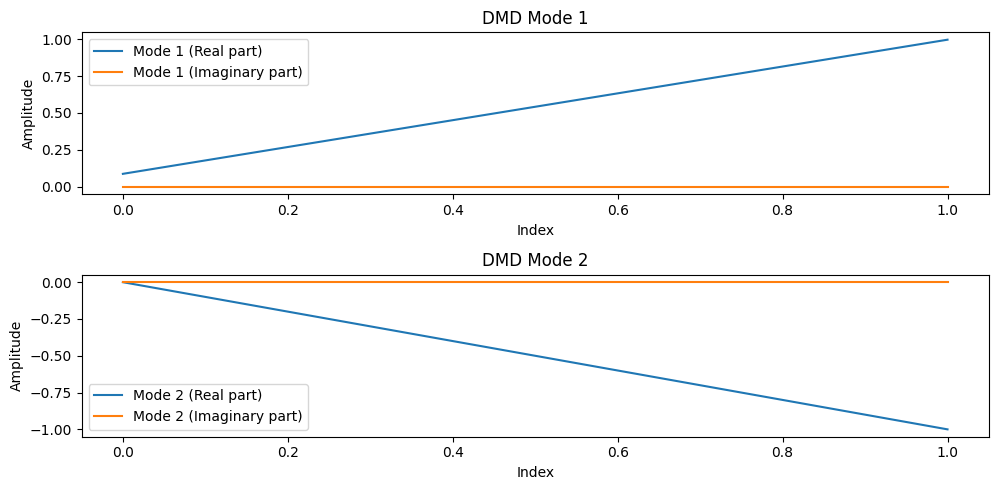

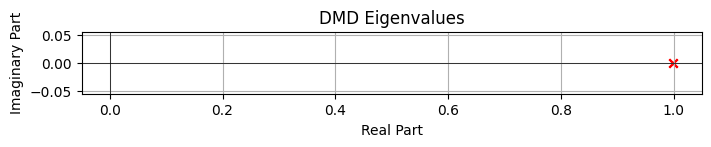

<ipython-input-27-f71928a25b23>:124: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(omega)), np.abs(omega), use_line_collection=True)


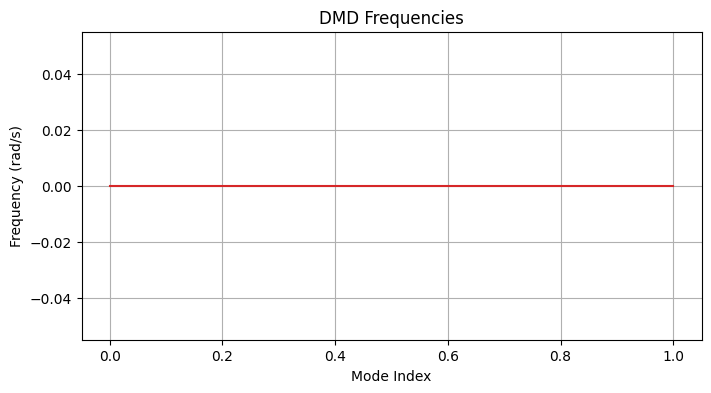

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


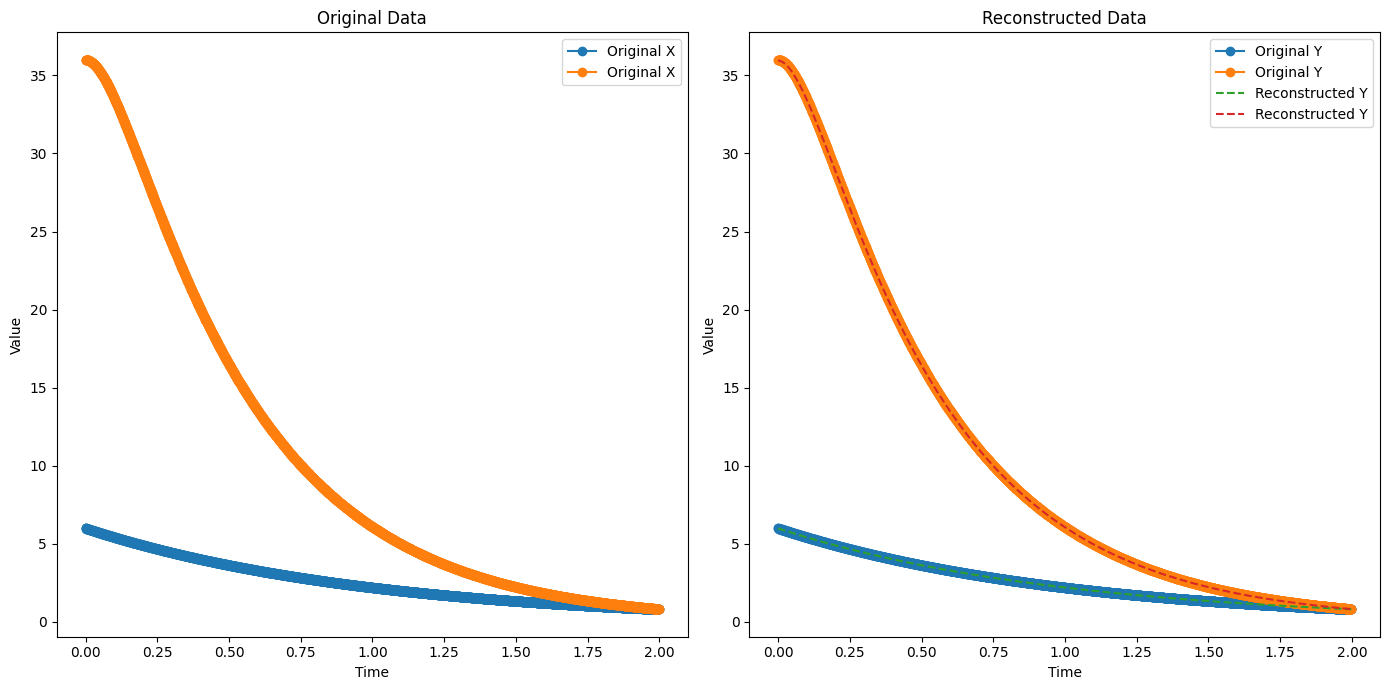

In [ ]:
# Example 1: Given system of
t = t_data
X1 = X[0:-1, :].T  # Example data
X2 = X[1:, :].T  # Shifted data

# Apply DMD
Phi, Lambda, omega = dynamic_mode_decomposition(X1, X2, r=2, delta_t=dt)

print("DMD Modes:\n", Phi)
print("DMD Eigenvalues:\n", Lambda)
print("DMD Frequencies:\n", omega)

#print(X1.shape,X2.shape)
# Plot results
plot_dmd_results(Phi, Lambda, omega)

plot_dynamics(X1, X2, Phi, Lambda, dt)

In [ ]:
!pip install pydmd
from pydmd import DMD
from pydmd.plotter import plot_summary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.5/169.5 kB 2.4 MB/s eta 0:00:00


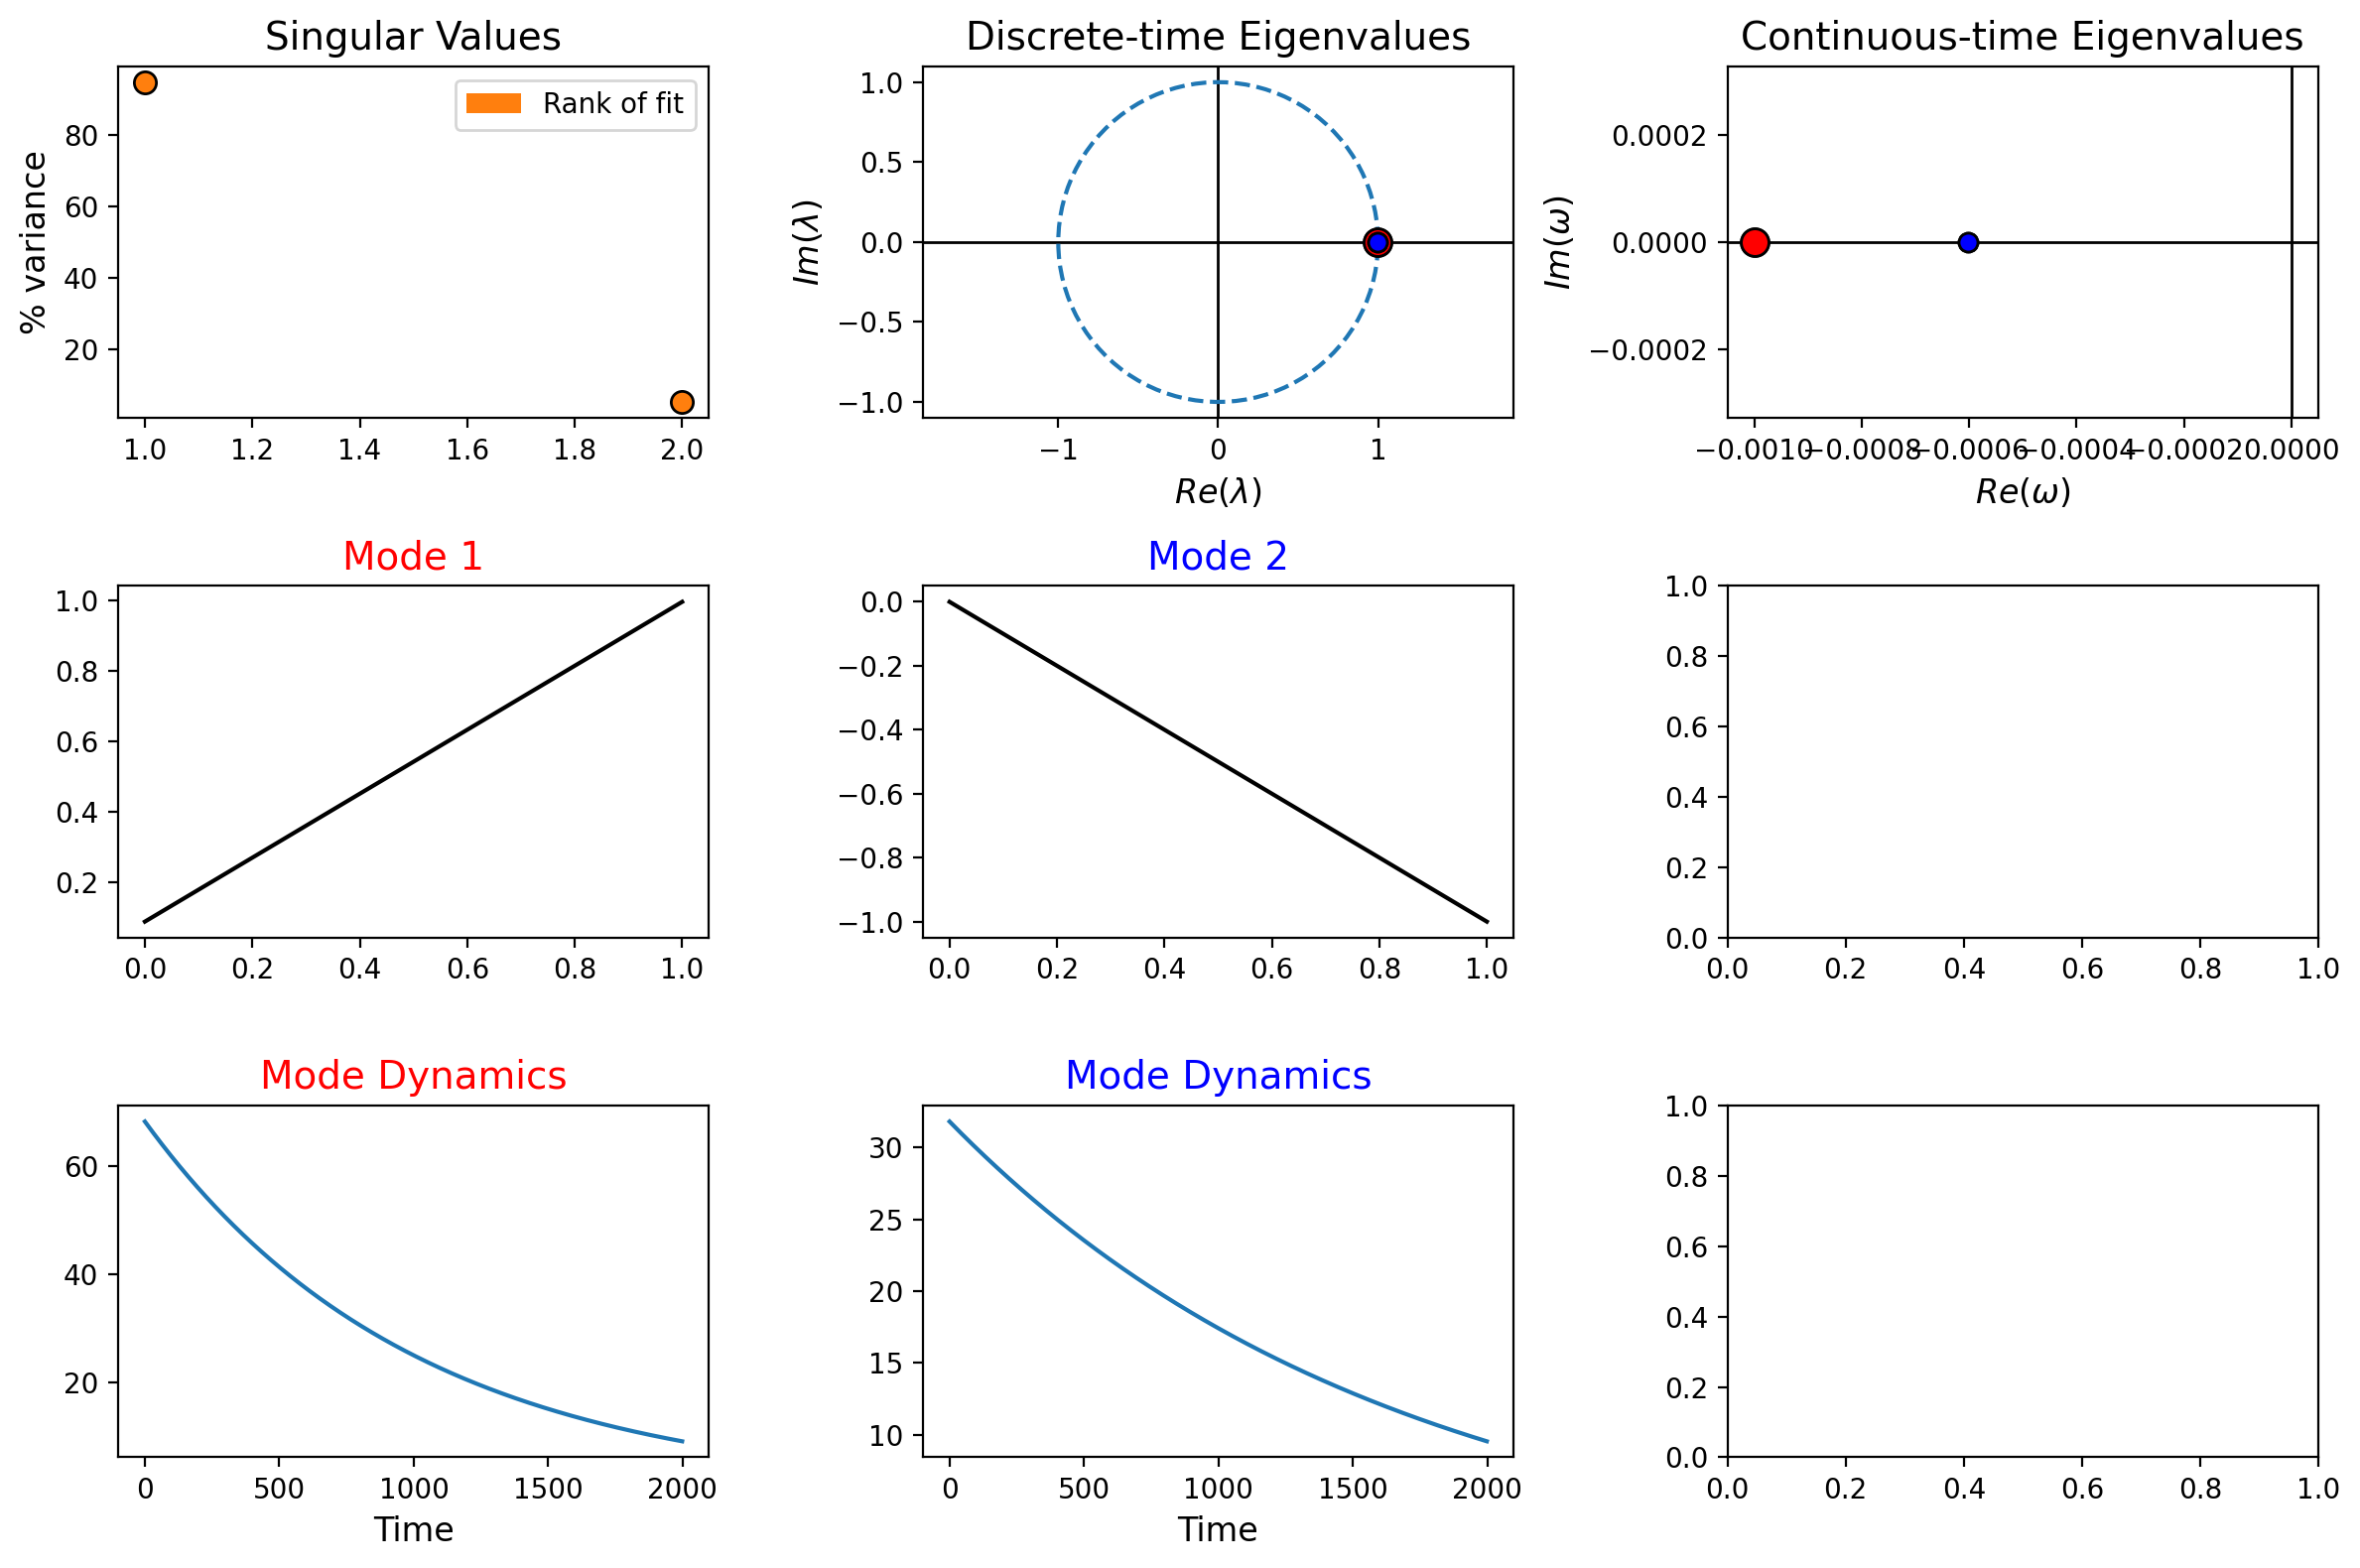

In [ ]:
# !pip install pydmd
# from pydmd import DMD
# from pydmd.plotter import plot_summary


# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=2,exact=True)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.
dmd.fit(X1,X2)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

In [ ]:
# Define ODE system with parameters
def ode(x, t):
    return [
        - x[1] + x[0]*(1 - x[0]**2 - x[1]**2),
        x[0] + x[1]*(1 - x[0]**2 - x[1]**2)
    ]

DMD Modes:
 [[ 0.        ]
 [ 0.01469315]
 [ 0.0292365 ]
 [ 0.04348182]
 [ 0.05728386]
 [ 0.07050193]
 [ 0.08300127]
 [ 0.09465447]
 [ 0.10534273]
 [ 0.11495708]
 [ 0.12339952]
 [ 0.13058399]
 [ 0.13643722]
 [ 0.14089957]
 [ 0.14392554]
 [ 0.14548427]
 [ 0.14555989]
 [ 0.14415161]
 [ 0.1412738 ]
 [ 0.13695579]
 [ 0.13124161]
 [ 0.1241895 ]
 [ 0.11587135]
 [ 0.10637198]
 [ 0.0957882 ]
 [ 0.08422793]
 [ 0.071809  ]
 [ 0.05865803]
 [ 0.04490907]
 [ 0.0307023 ]
 [ 0.01618254]
 [ 0.0014978 ]
 [-0.0132022 ]
 [-0.02776762]
 [-0.04204996]
 [-0.05590363]
 [-0.0691874 ]
 [-0.08176585]
 [-0.09351074]
 [-0.10430235]
 [-0.11403067]
 [-0.12259651]
 [-0.12991256]
 [-0.13590424]
 [-0.14051045]
 [-0.14368425]
 [-0.14539328]
 [-0.14562012]
 [-0.14436246]
 [-0.1416331 ]
 [-0.13745989]
 [-0.13188537]
 [-0.12496635]
 [-0.11677338]
 [-0.10738998]
 [-0.09691181]
 [-0.08544568]
 [-0.07310849]
 [-0.060026  ]
 [-0.04633159]
 [-0.03216485]
 [-0.01767022]
 [-0.00299544]
 [ 0.01170987]
 [ 0.0262958 ]
 [ 0.04061367

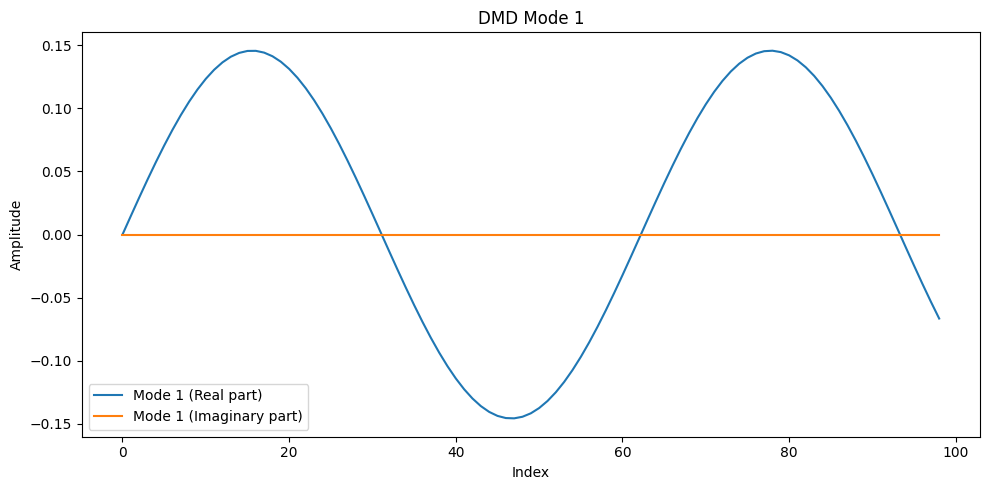

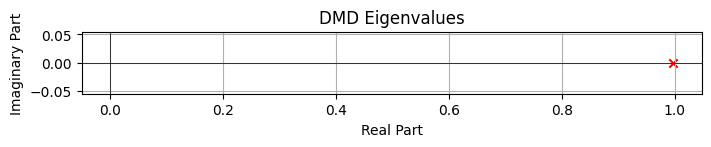

<ipython-input-6-bd91d7b65133>:124: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(omega)), np.abs(omega), use_line_collection=True)


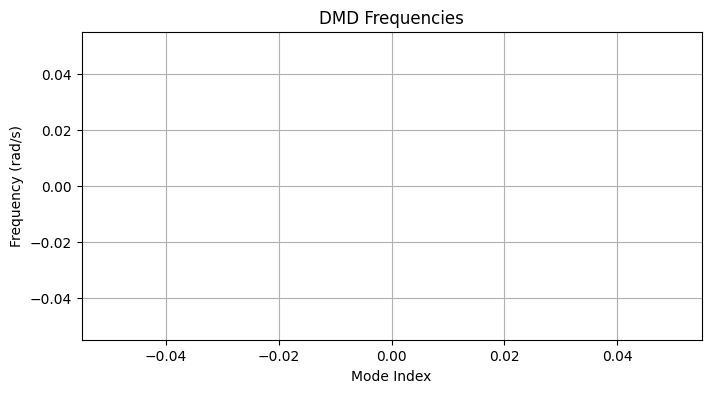

In [ ]:
t = np.linspace(0, 10, 100)
X = np.sin(t).reshape(-1, 1)
X1 = X[0:-1, :]  # Example data
X2 = X[1:, :]  # Shifted data

# Apply DMD
Phi, Lambda, omega = dynamic_mode_decomposition(X1, X2, r=2, delta_t = 0.1)

# Print results
print("DMD Modes:\n", Phi)
print("DMD Eigenvalues:\n", Lambda)
print("DMD Frequencies:\n", omega)

# Plot results
plot_dmd_results(Phi, Lambda, omega)

/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:696: UserWarning: Provided DMD model has less than 3 modes.Plotting all available modes...
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:840: RuntimeWarning: invalid value encountered in divide
  ms_vals = max_eig_ms * np.sqrt(lead_amplitudes / lead_amplitudes[0])
/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:944: RuntimeWarning: invalid value encountered in scalar divide
  if dynamics_range / np.abs(np.average(dynamics_data)) < 1e-4:


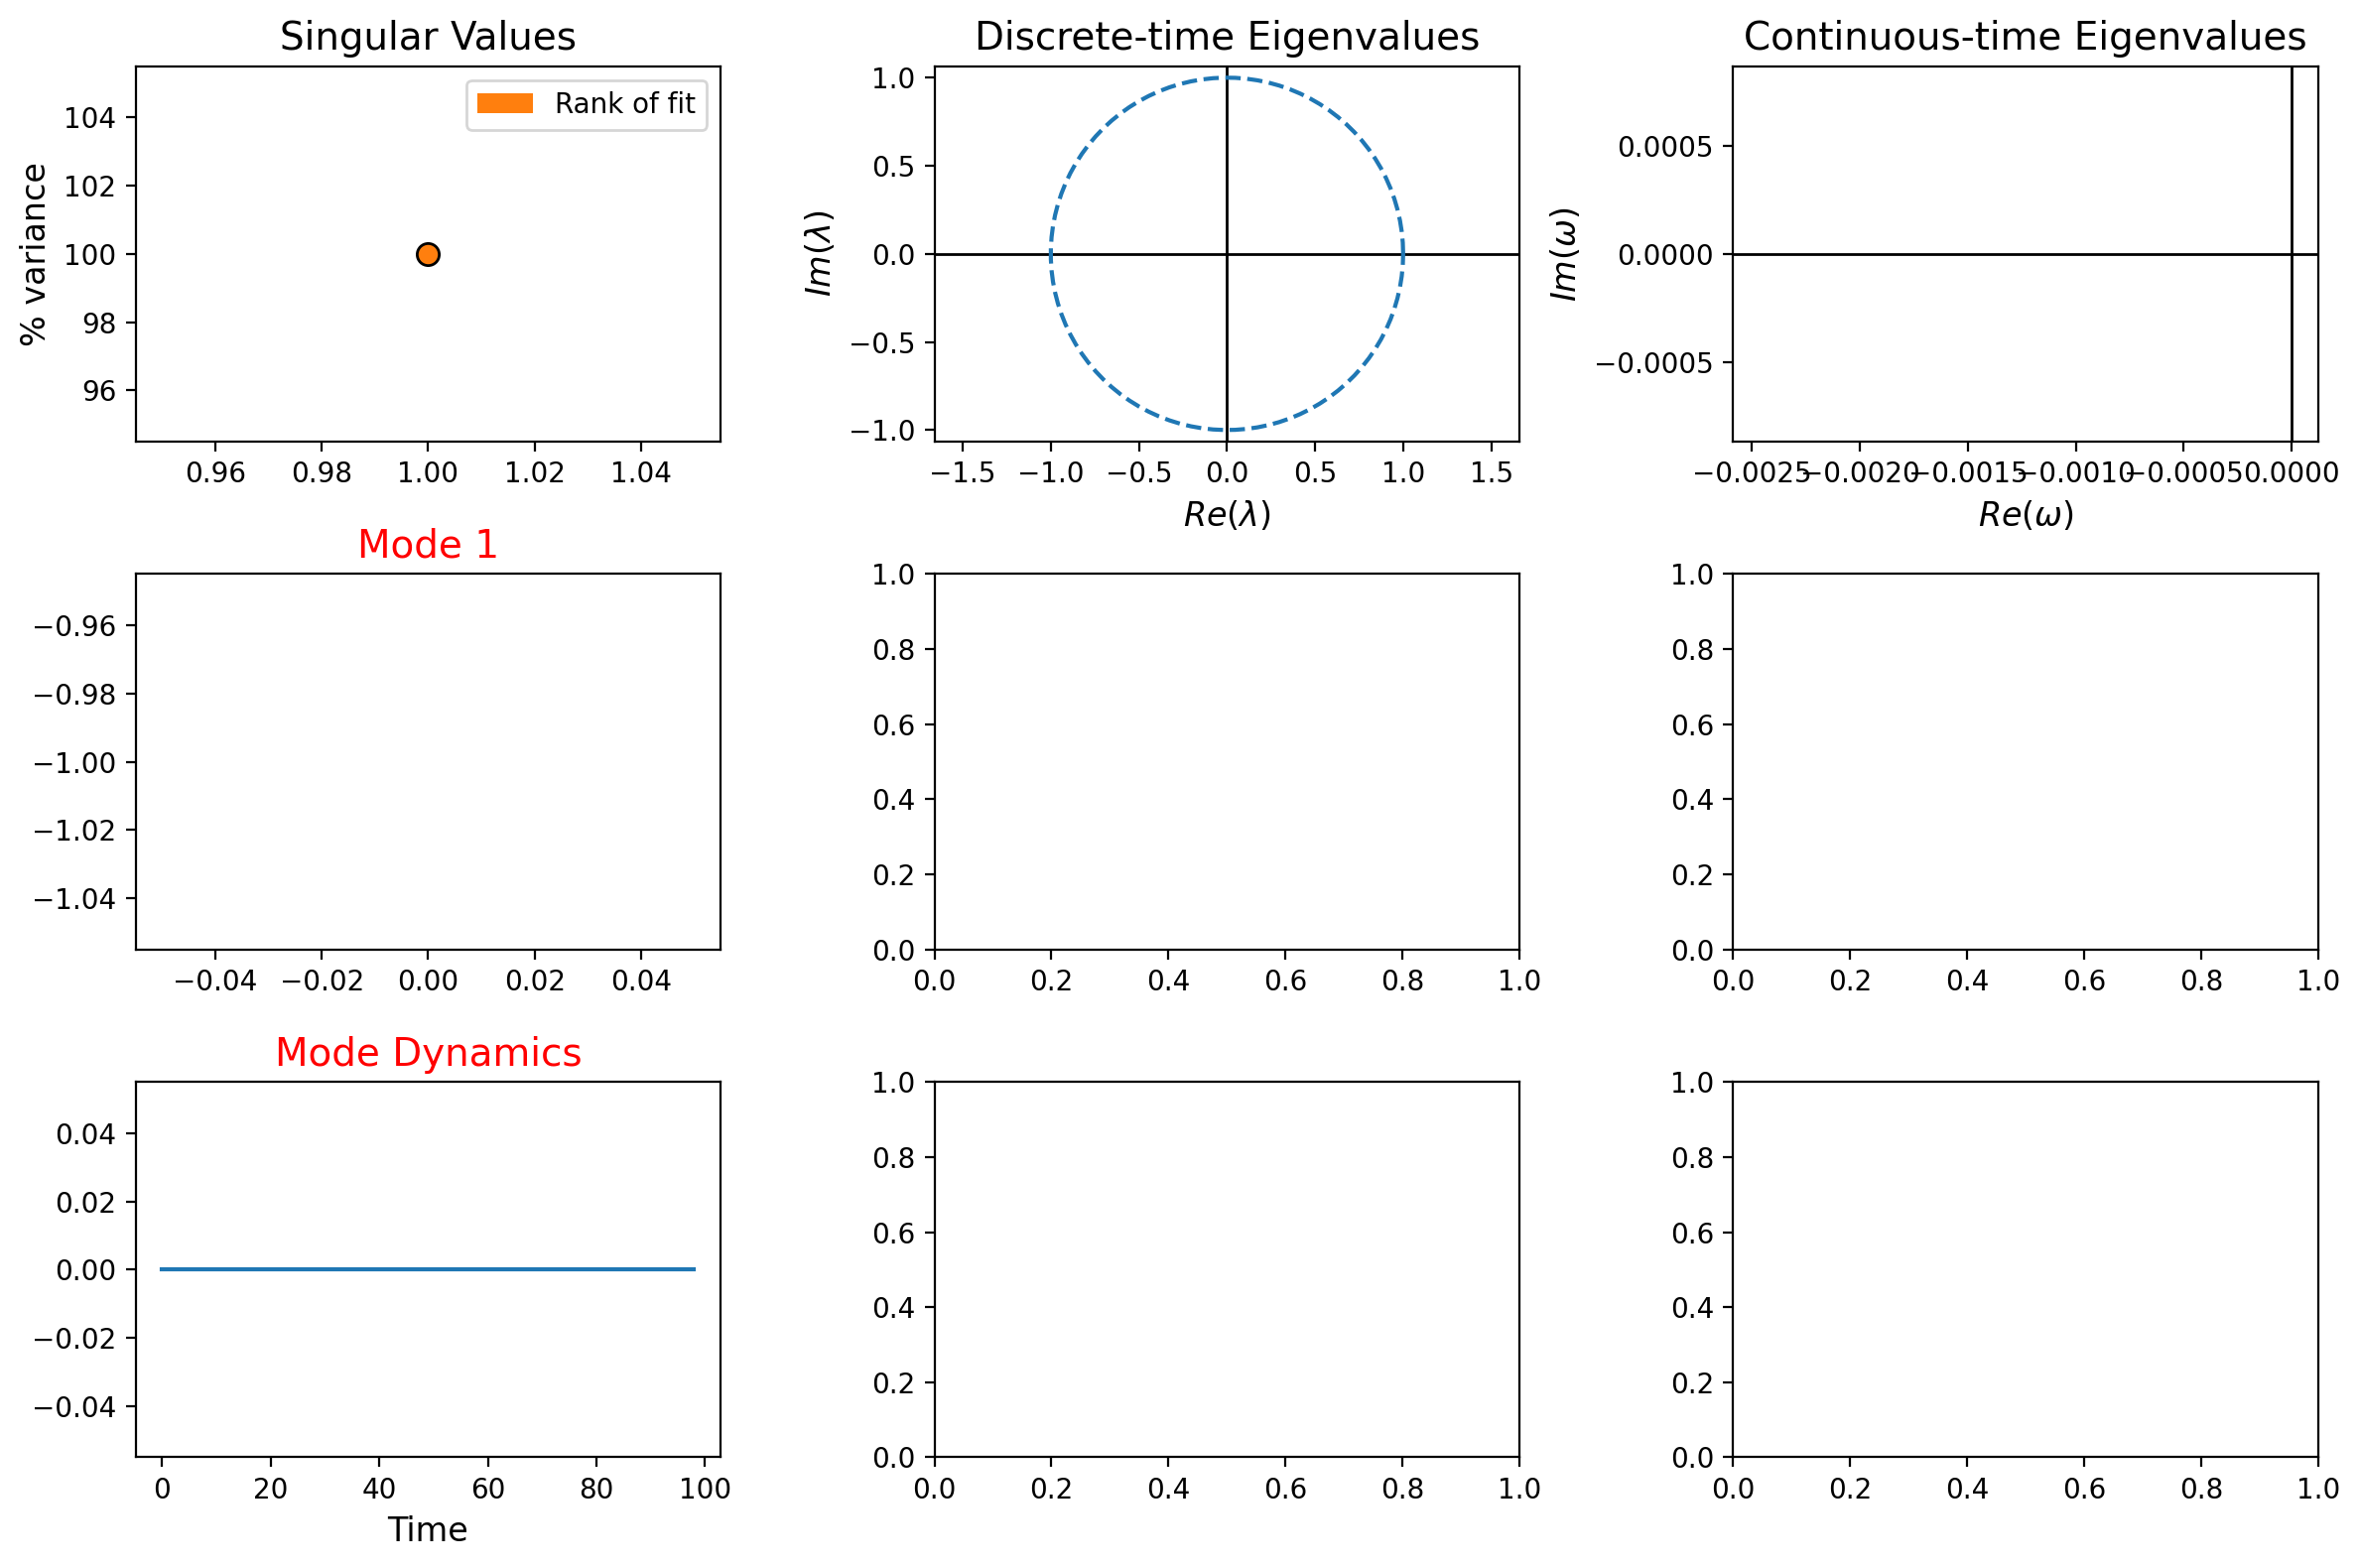

In [ ]:
#!pip install pydmd
from pydmd import DMD
from pydmd.plotter import plot_summary

# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=2,exact=False)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd.fit(X1.T,X2.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

We create the input data by summing two different functions:<br>
$f_1(x,t) = \text{sech}(x+3)\cos(2.3t)$<br>
$f_2(x,t) = 2\text{sech}(x)\tanh(x)\sin(2.8t)$.<br>

In [ ]:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.cos(2.3 * t)


def f2(x, t):
    return 2.0 / np.cosh(x) * np.tanh(x) * np.sin(2.8 * t)


nx = 65  # number of grid points along space dimension
nt = 129  # number of grid points along time dimension

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0]  # time step between each snapshot

# Data consists of 2 spatiotemporal signals.
X1n = f1(xgrid, tgrid)
X2n = f2(xgrid, tgrid)
Xn = X1n + X2n

# Make a version of the data with noise.
#mean = 0
#std_dev = 0.2
#random_matrix = np.random.normal(mean, std_dev, size=(nt, nx))
#Xn = X + random_matrix

Xn.shape

(129, 65)

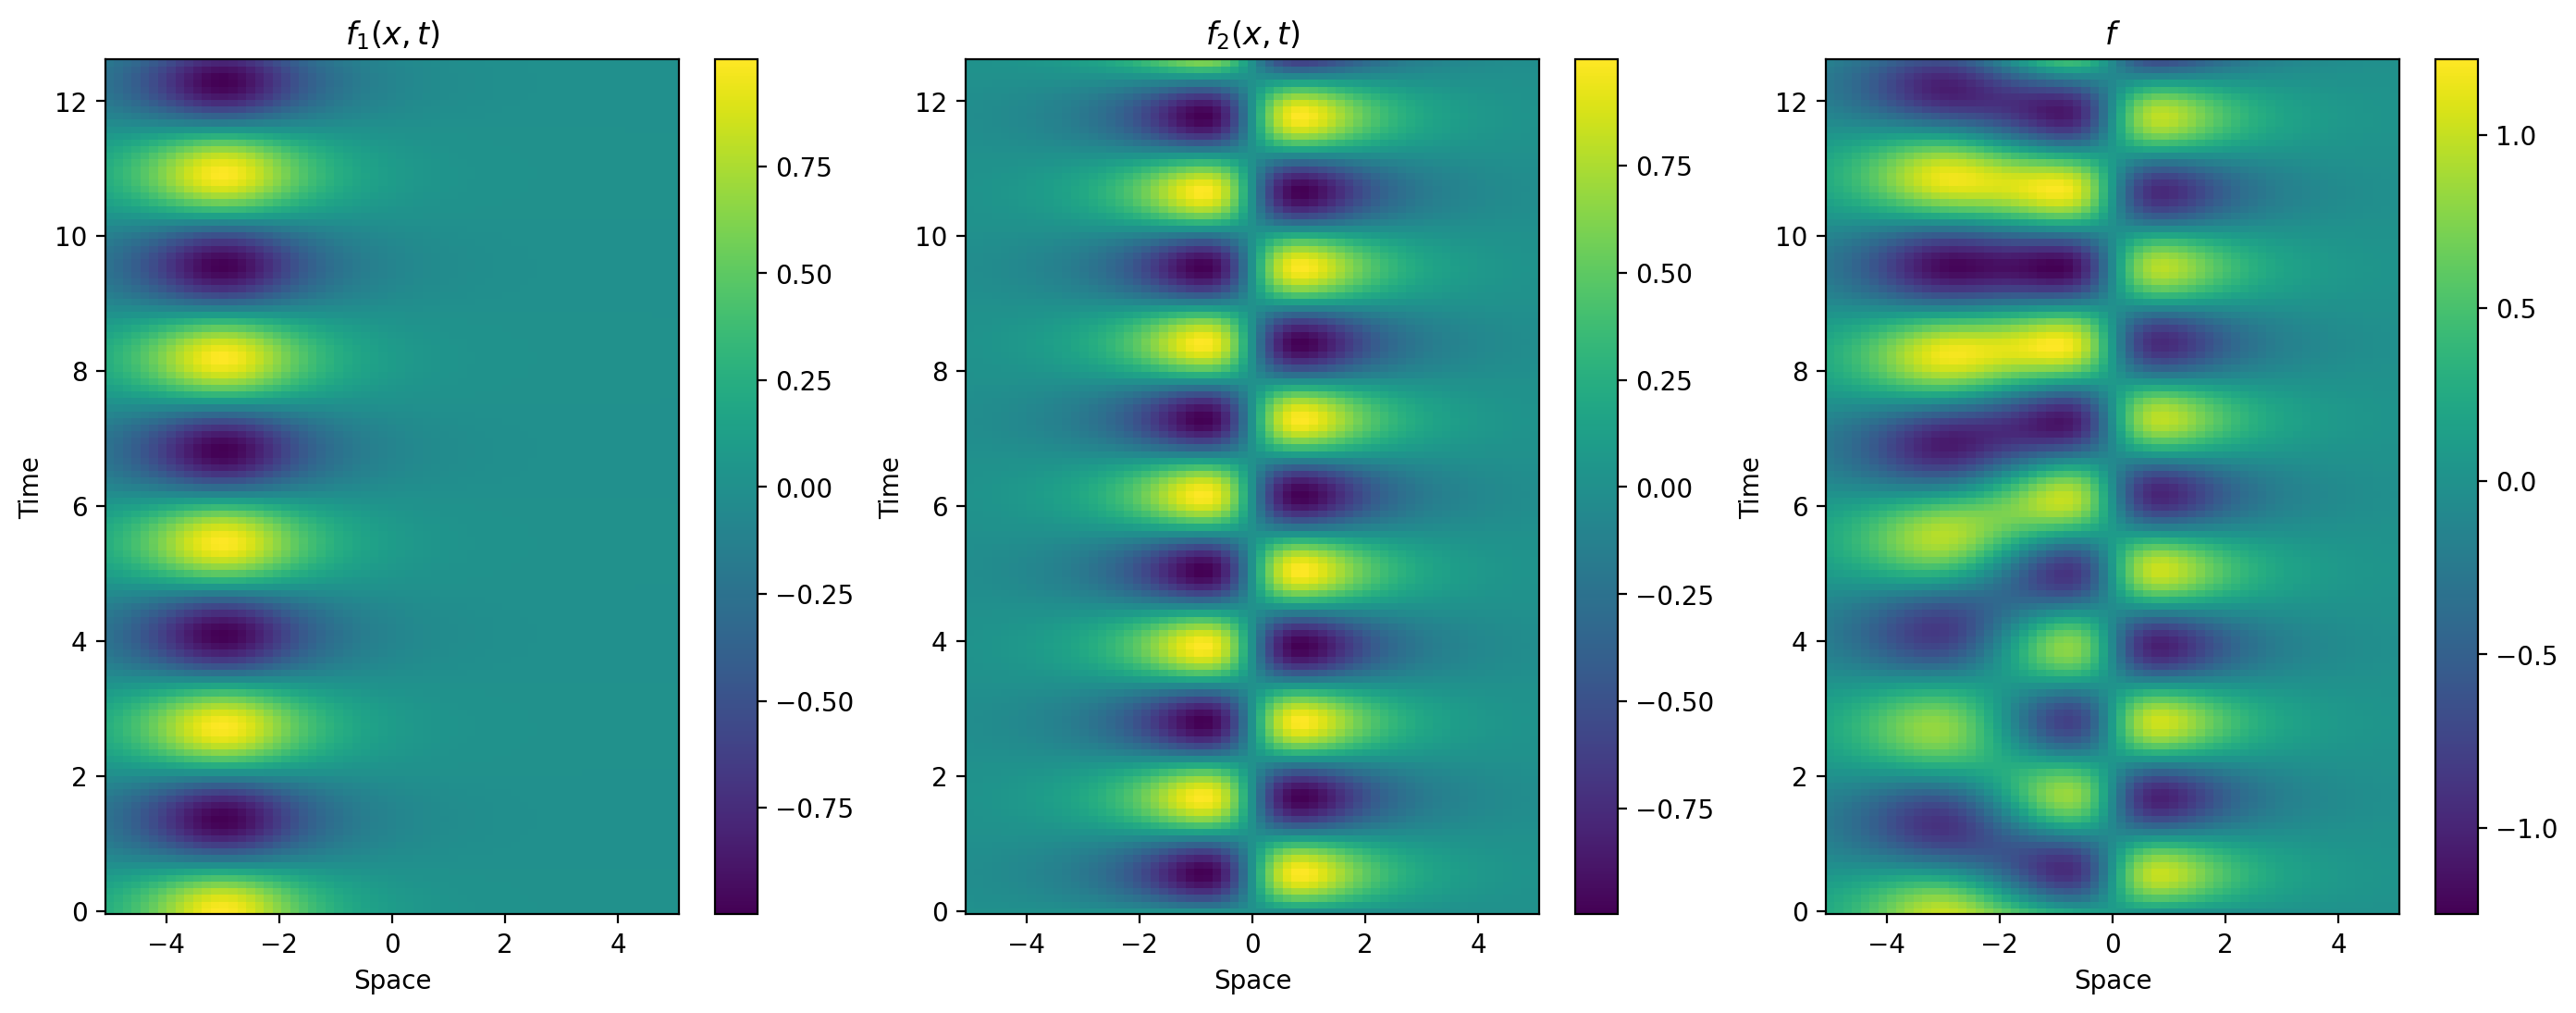

In [ ]:
# Visulaization of function
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$"]
data = [X1n, X2n, Xn]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

## DMD with perfect data (i.e. clean simulation data)

**We begin by presenting the following results so that we know what we should be expecting when we apply DMD to this data set. We will go more in depth about the individual steps on how to use PyDMD later.**

Notice that by construction, our data set is completely real (i.e. it doesn't possess imaginary components) and it contains 2 distinct spatiotemporal features that oscillate in time. Hence a successful DMD model should not only be able to faithfully reconstruct the input data, but it should also be able to disambiguate the 2 spatial modes, as well as recover their respective frequencies of oscillation $\omega_1=2.3$ and $\omega_2=2.8$.

To capture such oscillations from real data sets, we will need 2 DMD eigenvalues for each oscillation: one to capture the frequency of the oscillation and one to capture its complex conjugate. Hence for our particular data set, we need at least 4 DMD eigenvalues / modes in order to capture the full extent of our data. We will also need time-delay data preprocessing in order to recover this rank-4 structure, but more on that later.

Since our data is evenly-spaced in time and sufficiently high-dimensional after we appropriately preprocess our data, exact DMD (implemented by `DMD`) is able to successfully extract the 2 spatiotemporal modes that make up our system as long as we use clean data.

**The results presented below are essentially perfect results.**

/usr/local/lib/python3.10/dist-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3.130212244191263e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydmd/plotter.py:696: UserWarning: Provided DMD model has less than 3 modes.Plotting all available modes...
  warnings.warn(


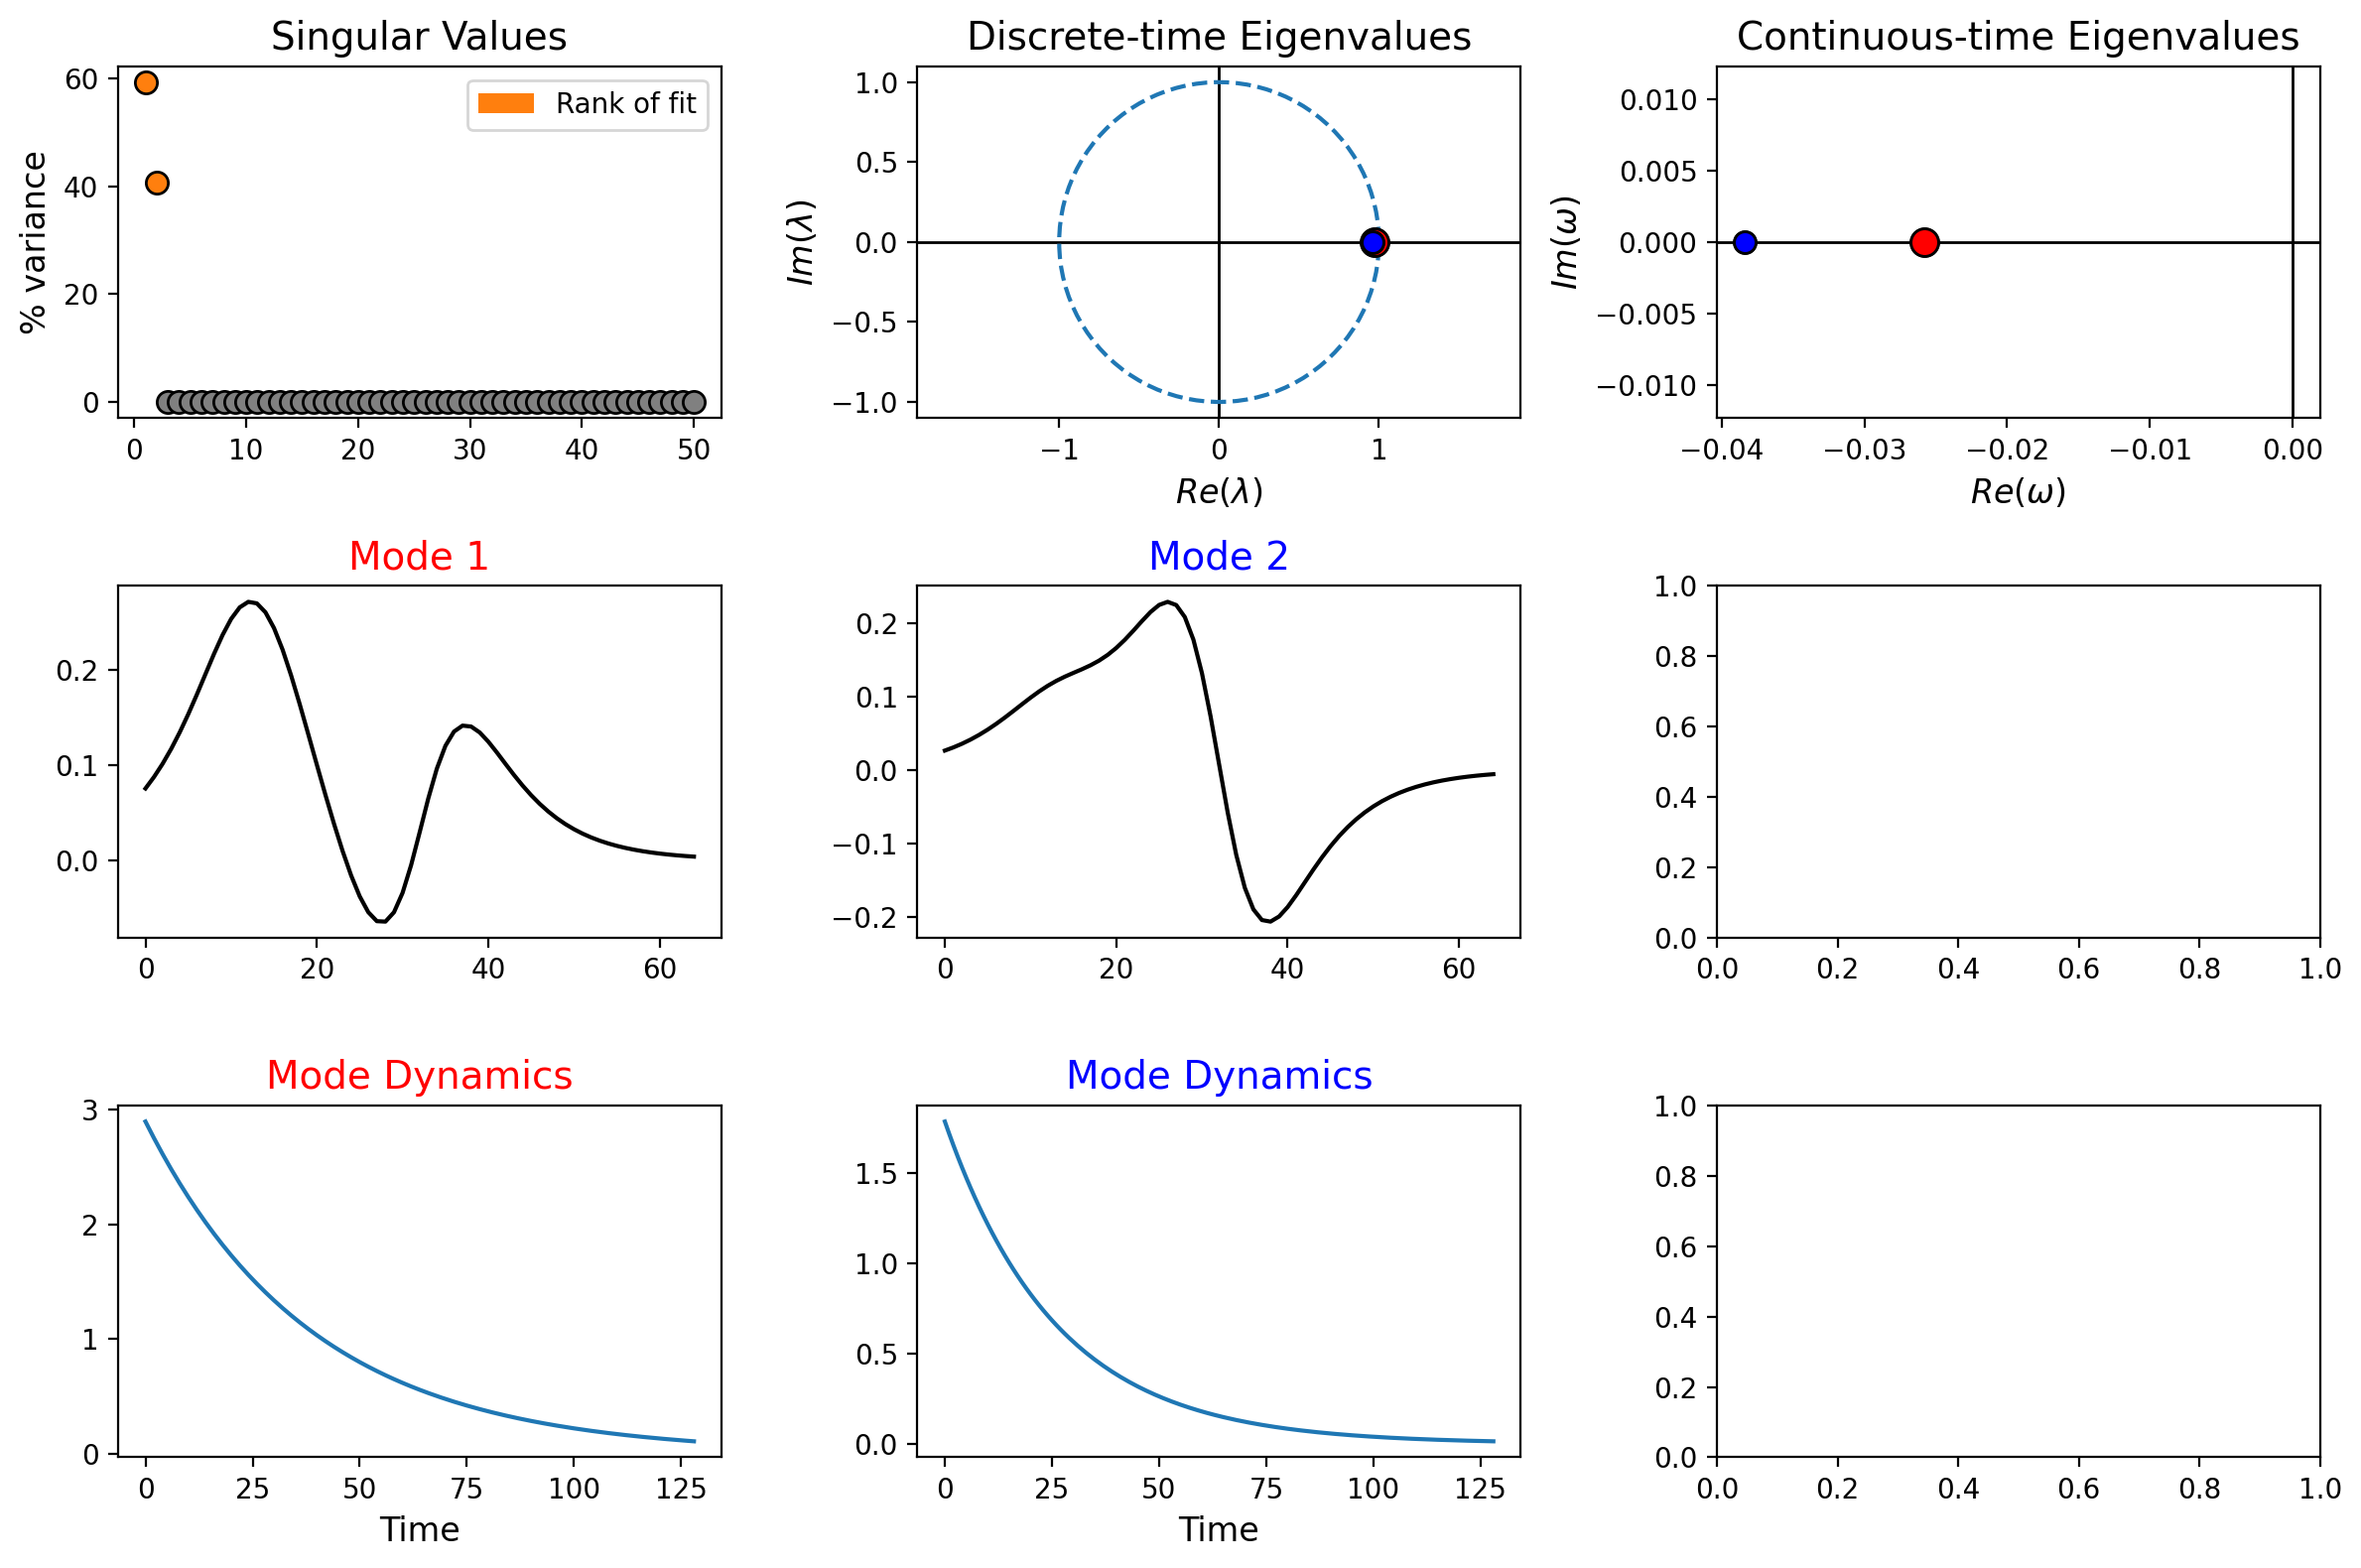

In [ ]:
from pydmd import DMD
from pydmd.plotter import plot_summary

# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=2,exact=False)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd.fit(Xn.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

/usr/local/lib/python3.10/dist-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1.4043110490916382e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


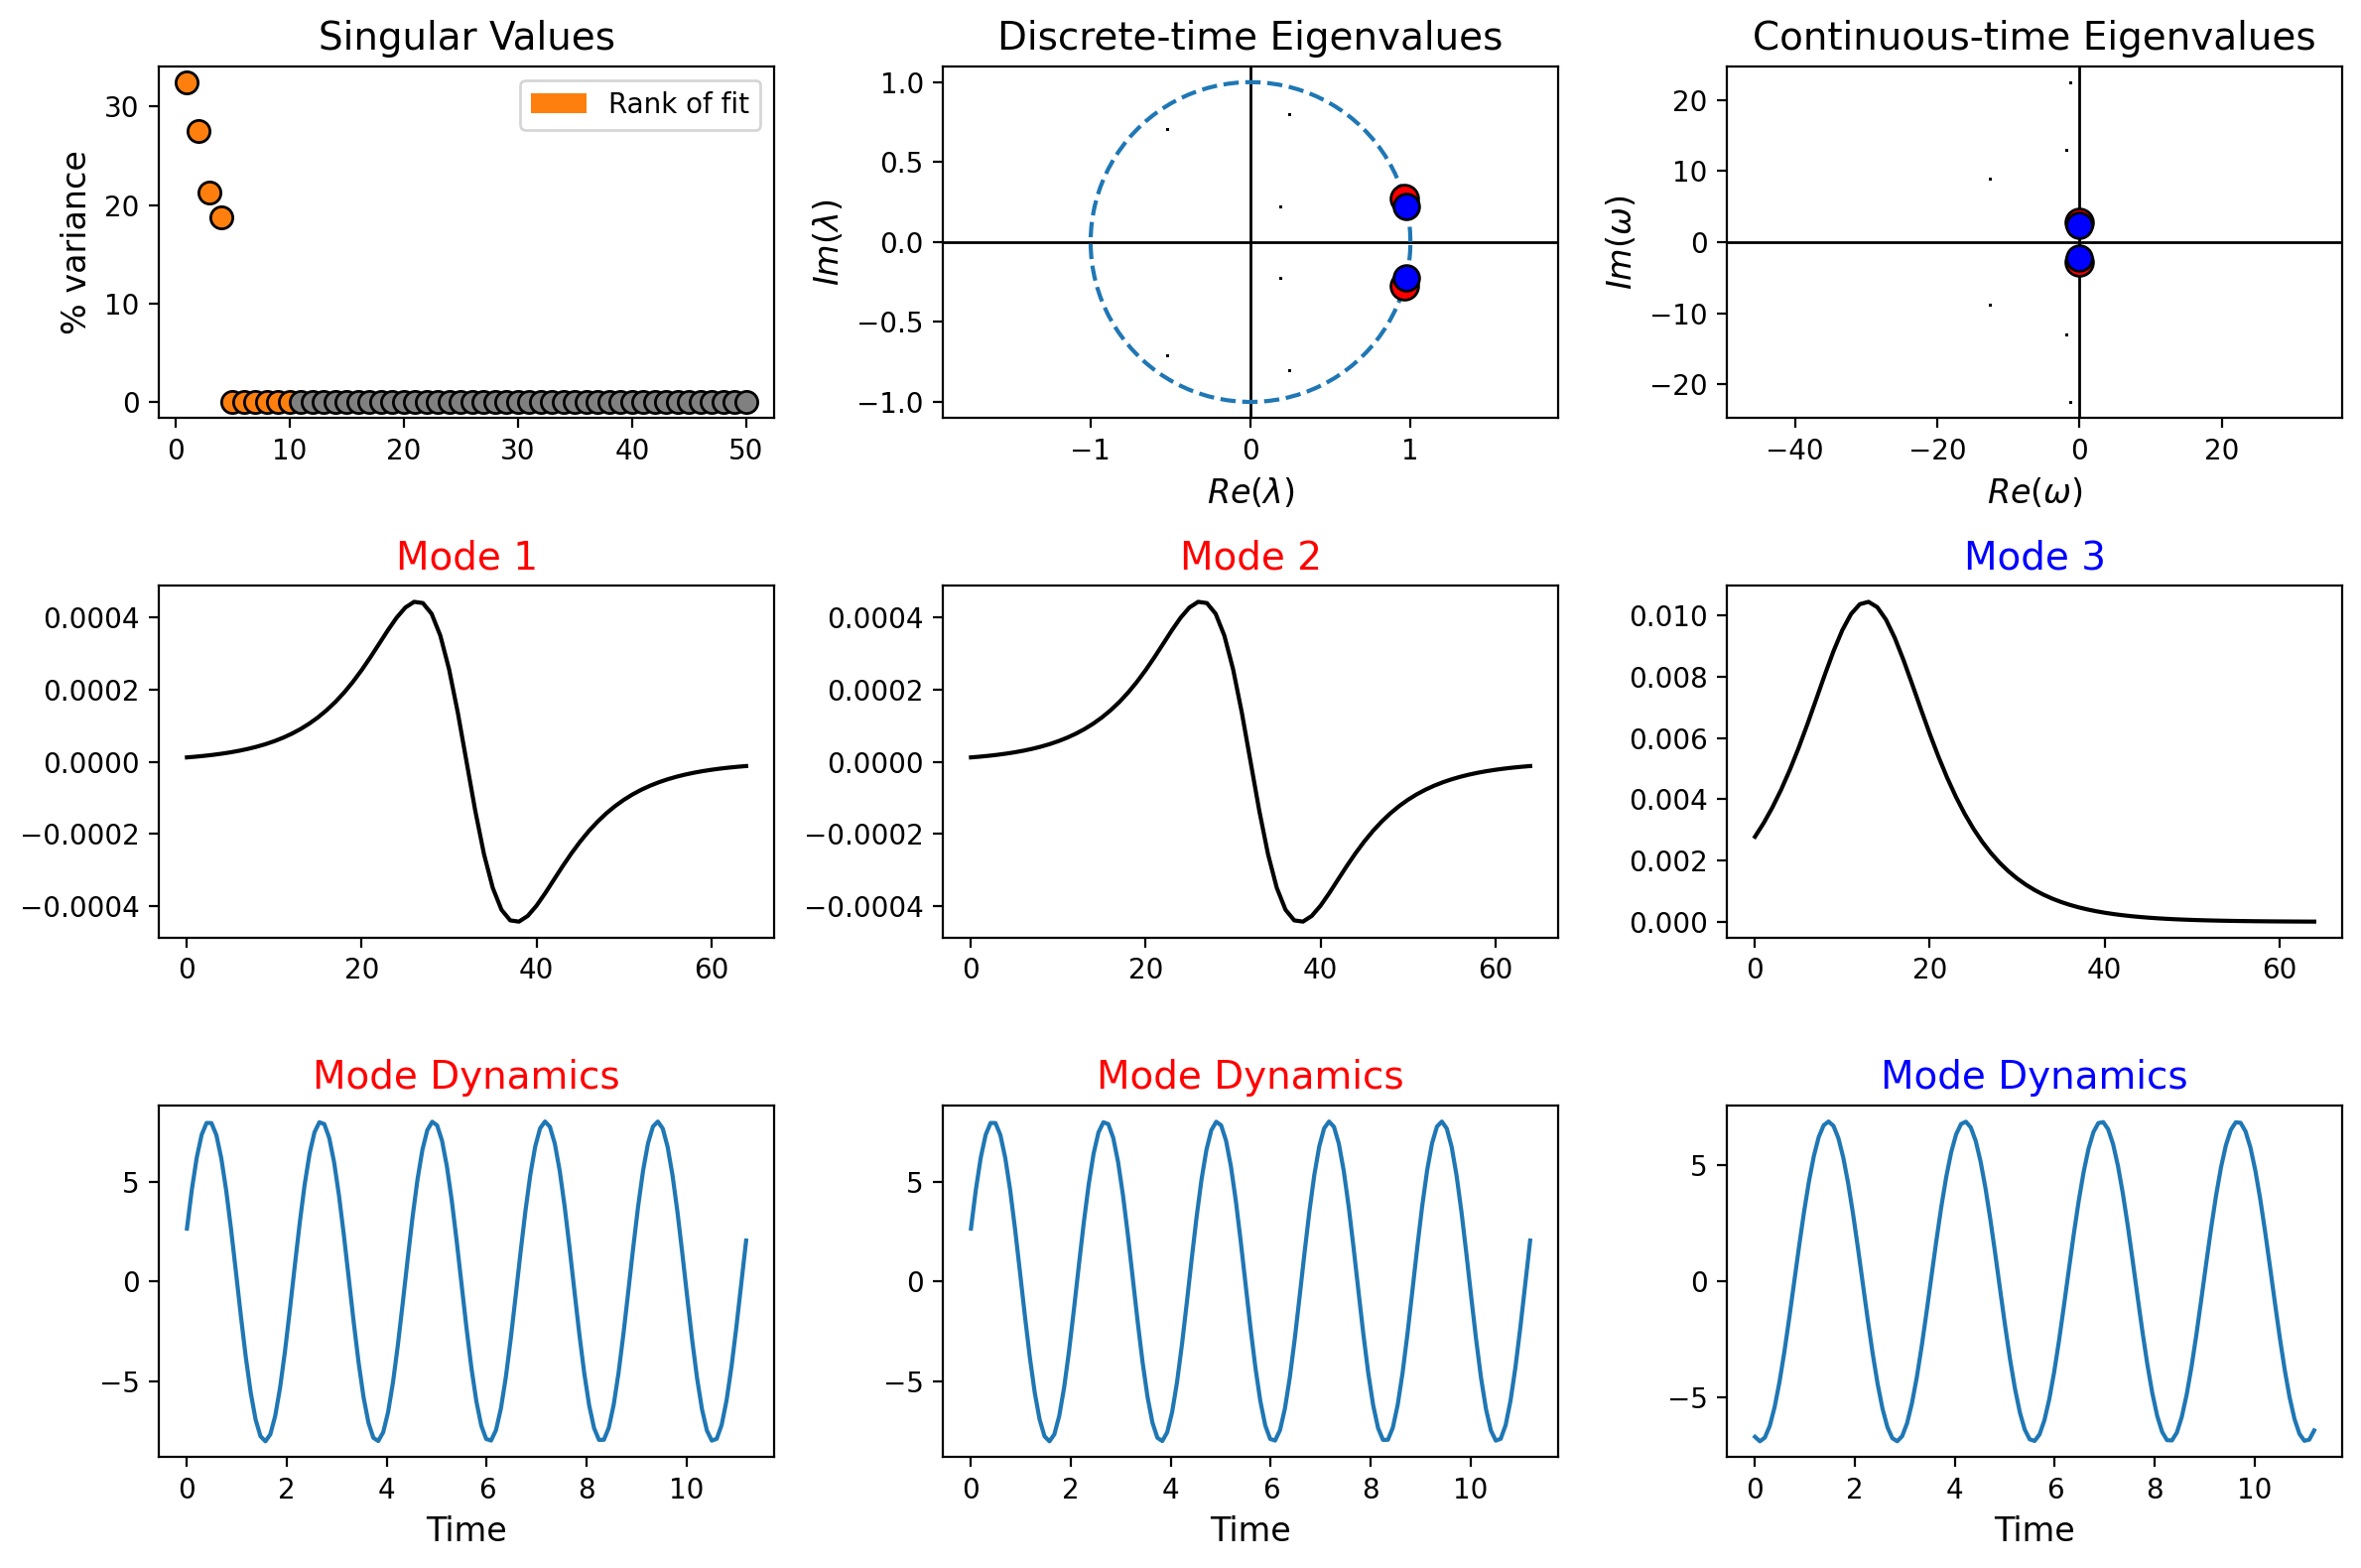

In [ ]:
from pydmd import DMD
from pydmd.plotter import plot_summary
from pydmd import preprocessing

dchosen = 15
# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=10,exact=False)

dmd1 = preprocessing.hankel_preprocessing(dmd, d=dchosen)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd1.fit(Xn.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd1, t = dt, d=dchosen)


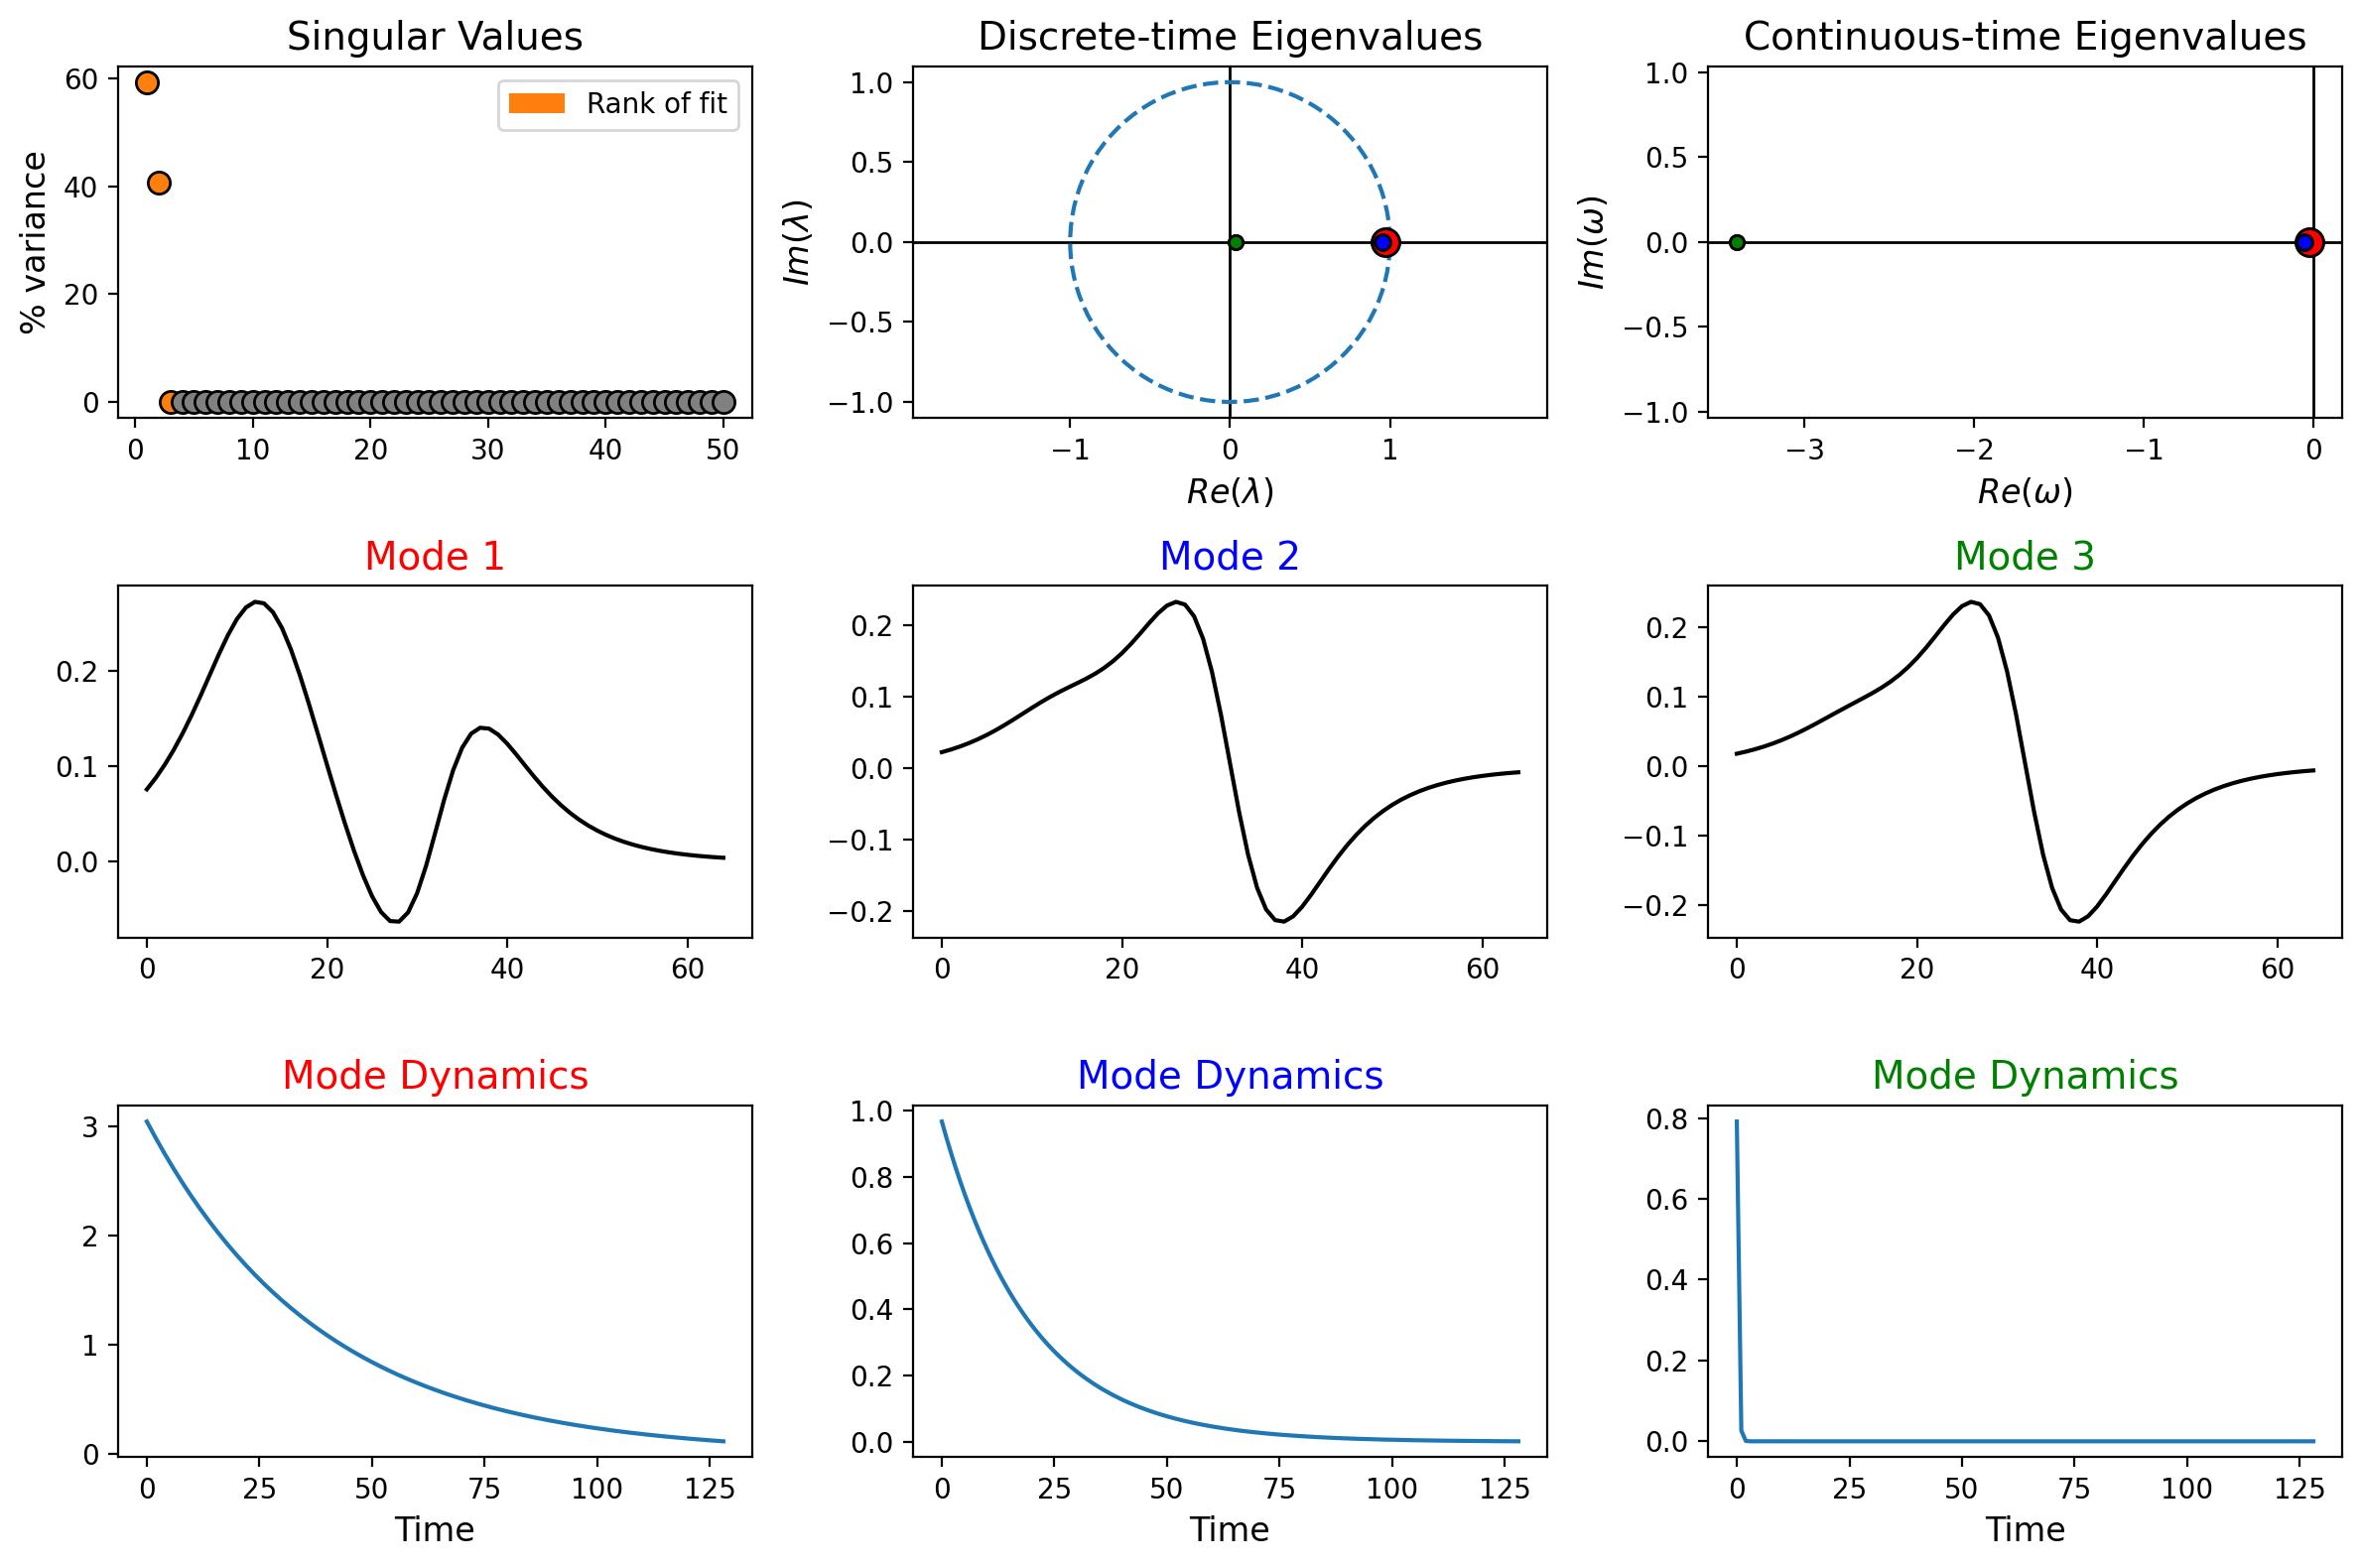

In [ ]:
from pydmd import DMD
from pydmd.plotter import plot_summary

# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=3,exact=False)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd.fit(X.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

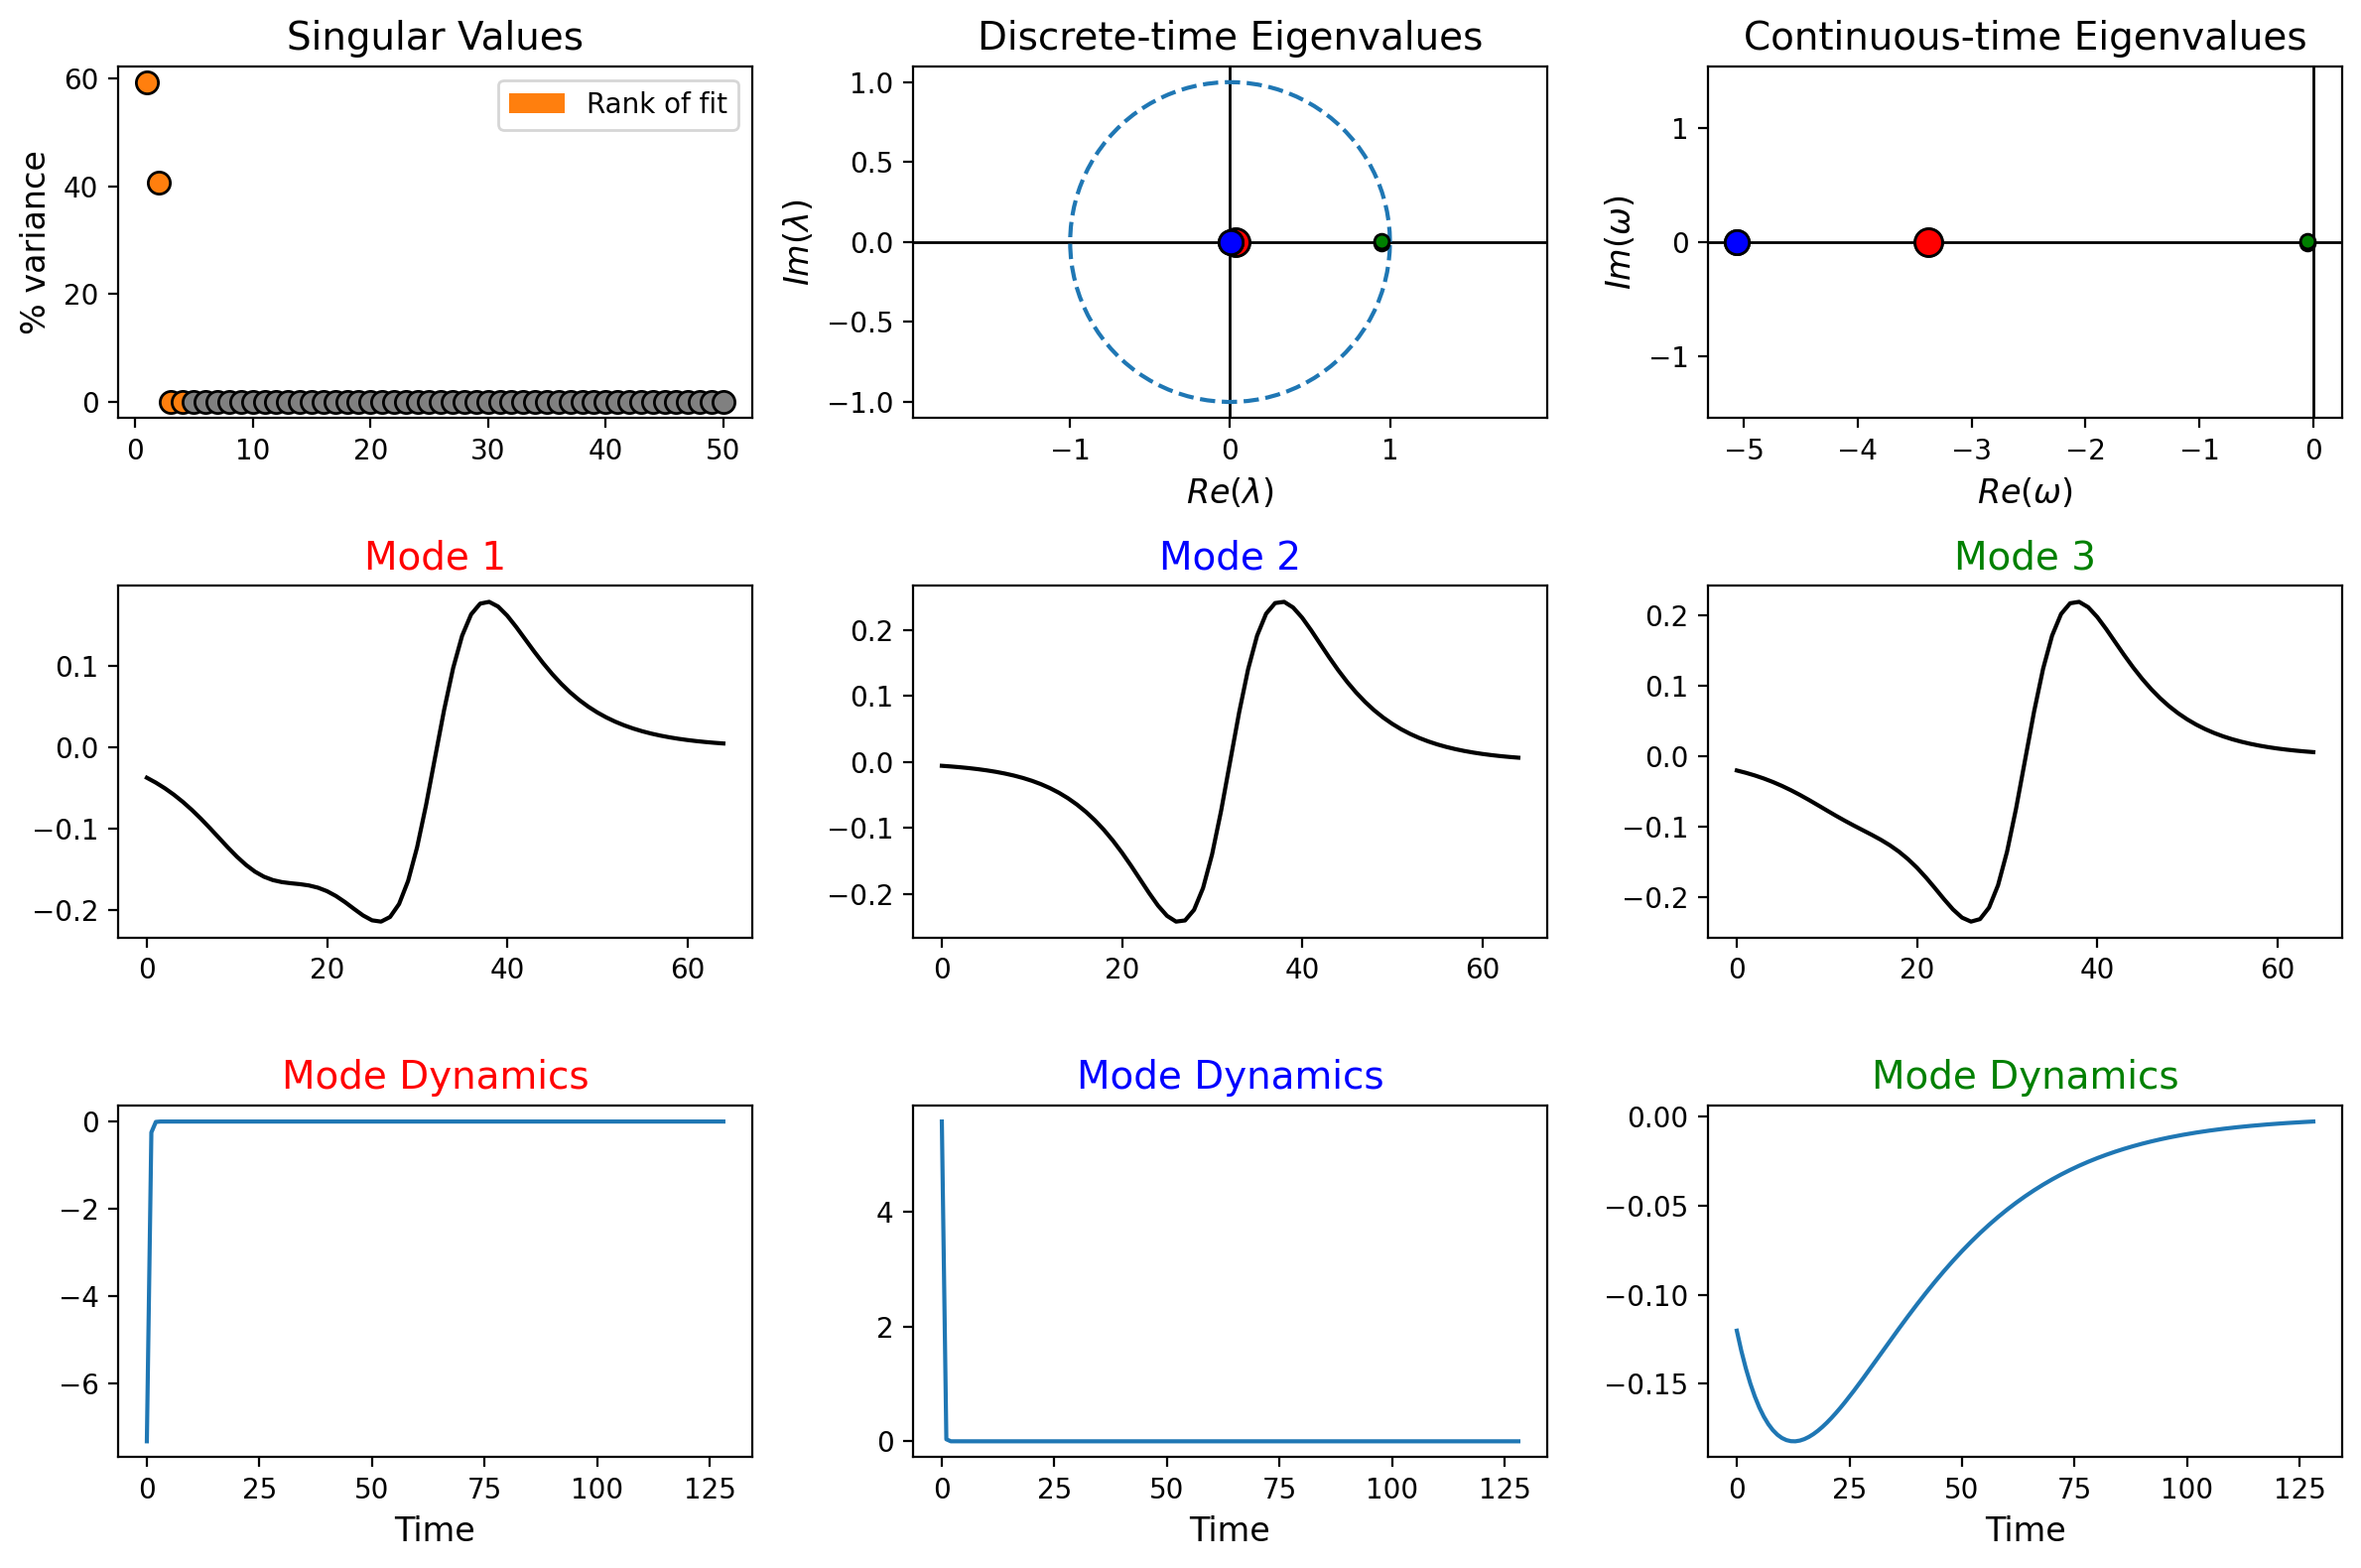

In [ ]:
from pydmd import DMD
from pydmd.plotter import plot_summary

# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=4,exact=False)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd.fit(X.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

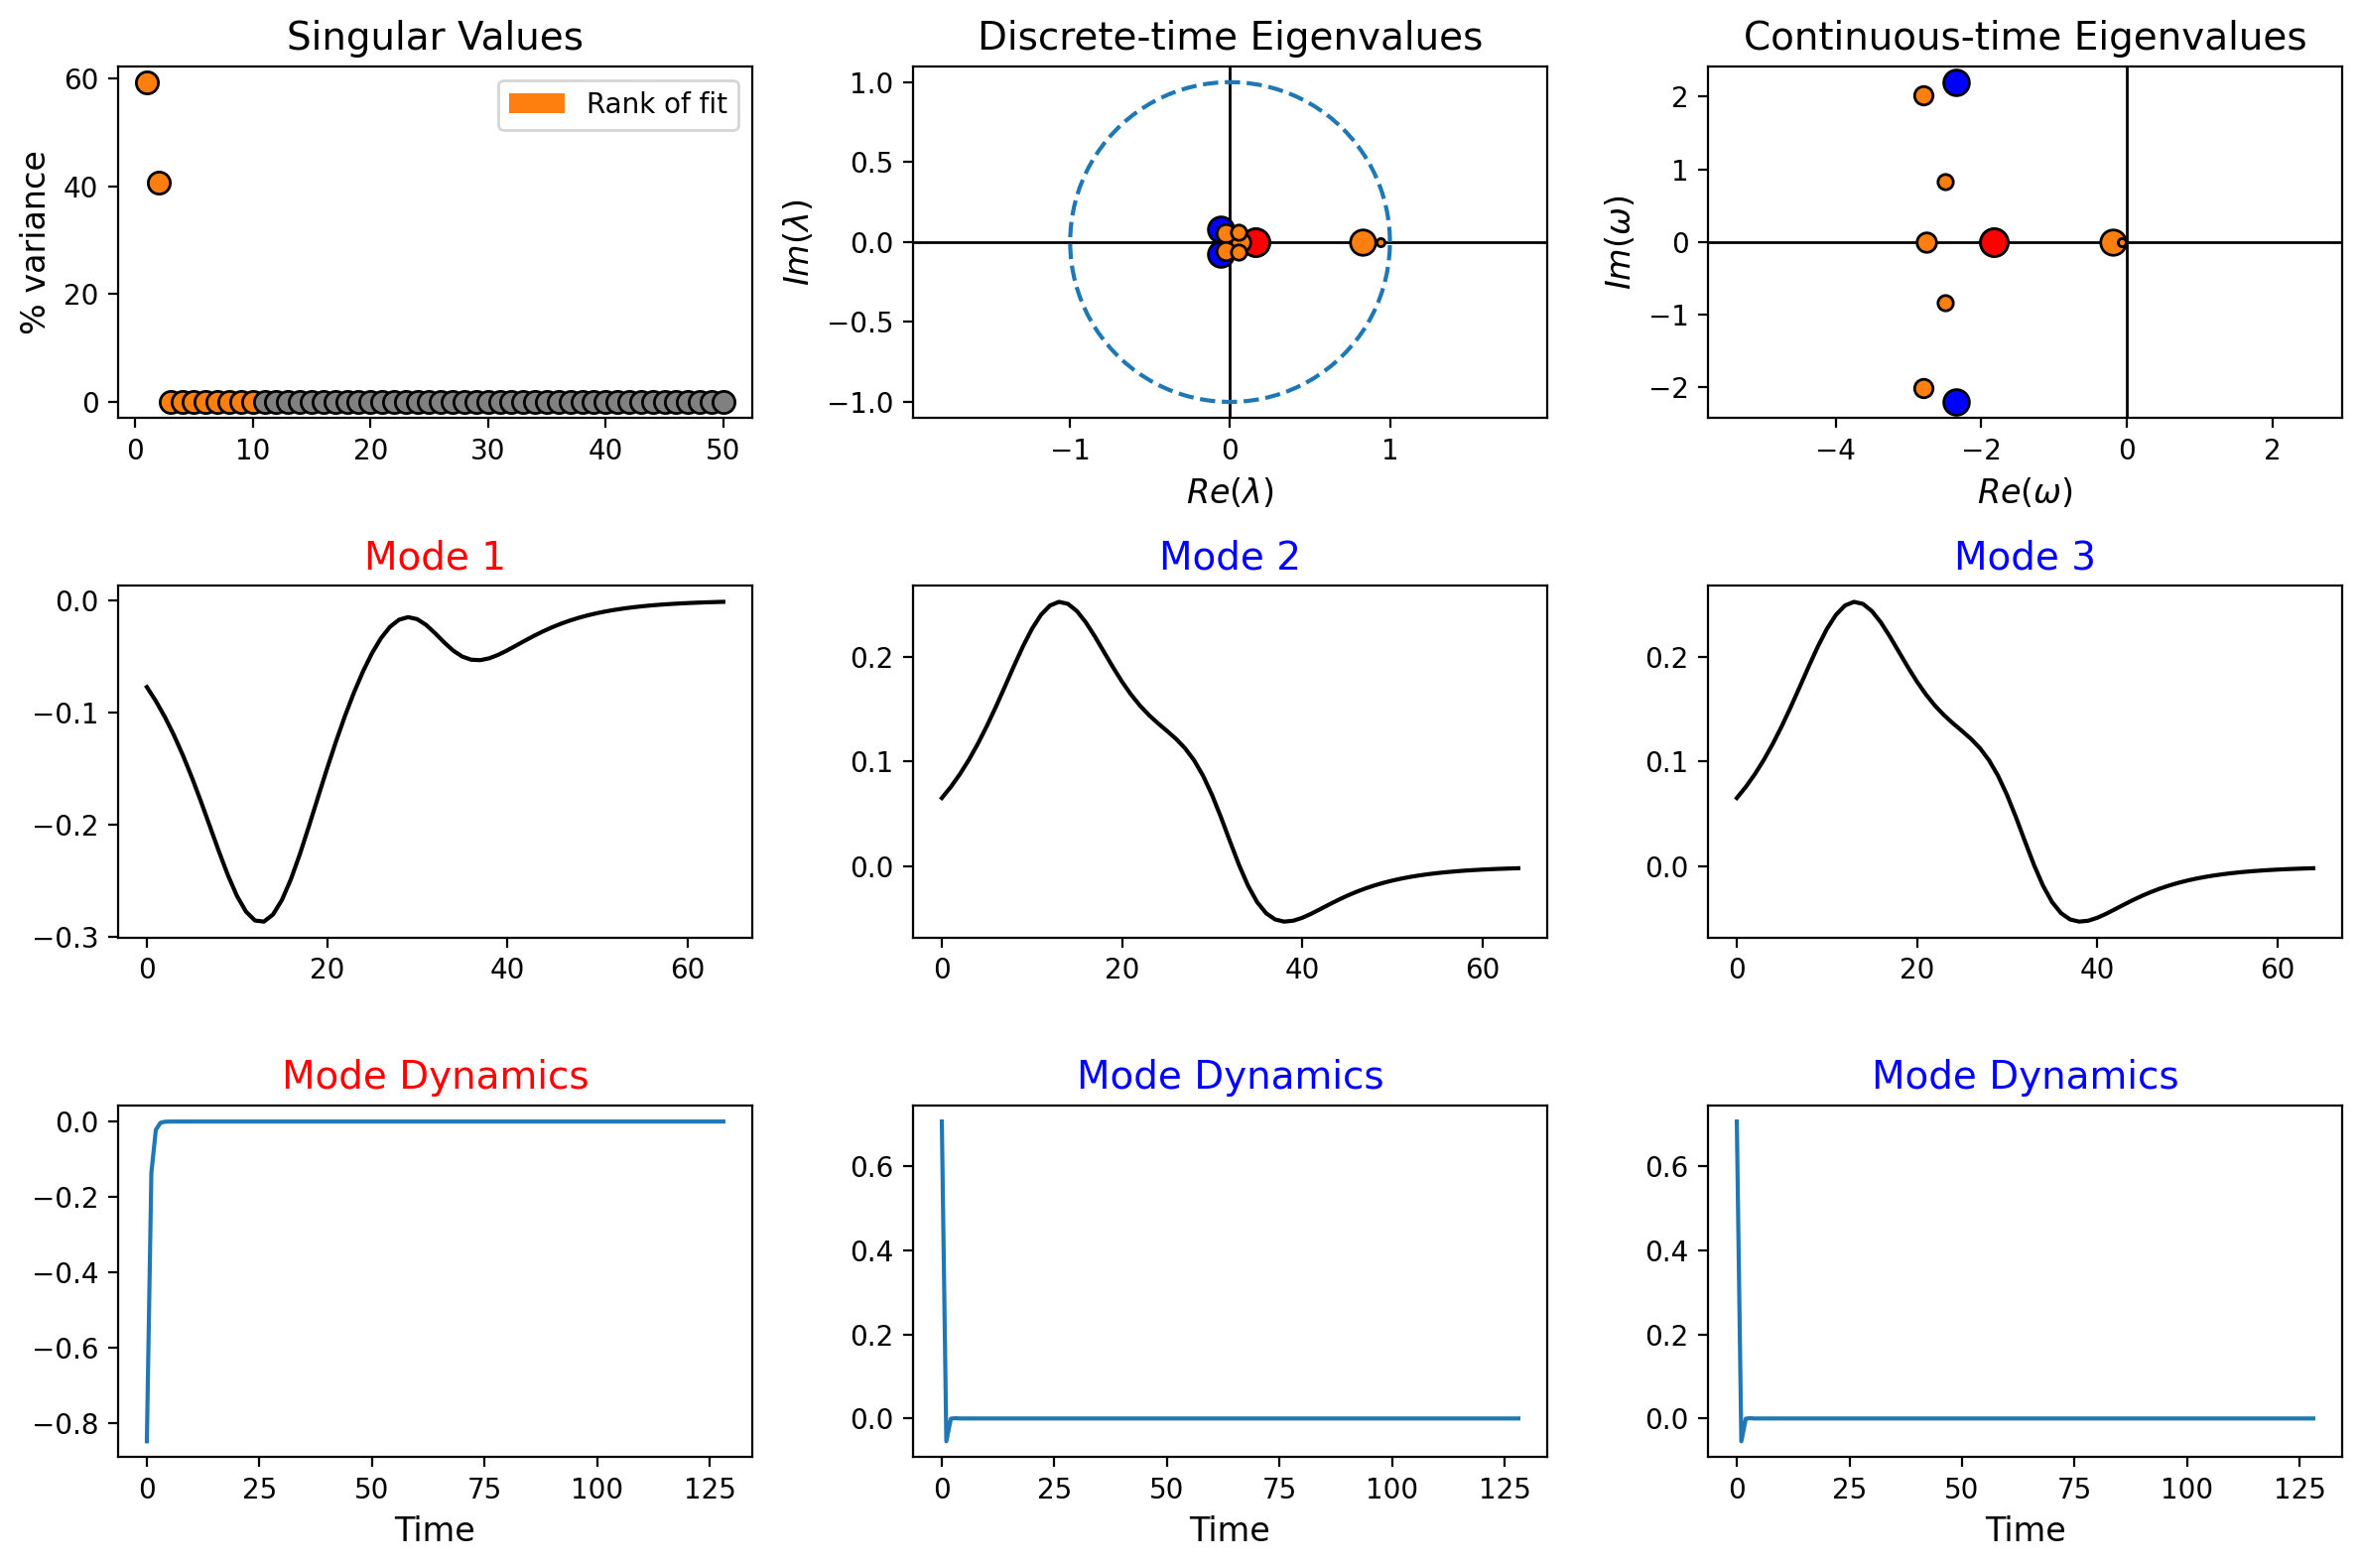

In [ ]:
from pydmd import DMD
from pydmd.plotter import plot_summary

# Build an exact DMD model with 12 spatiotemporal modes.
dmd = DMD(svd_rank=10,exact=False)

# Fit the DMD model.
# X = (n, m) numpy array of time-varying snapshot data.

dmd.fit(X.T)

# Plot a summary of the key spatiotemporal modes.
plot_summary(dmd)

DMD Modes:
 [[ 7.42773595e-02  2.61214743e-01  2.65641766e-02  7.53263994e-02]
 [-1.73101379e-02  8.11703517e-02  3.08961401e-02  8.74617323e-02]
 [-3.22558835e-02  1.26442209e-01  3.58686594e-02  1.01303173e-01]
 [ 3.57705925e-02 -5.19025523e-02  4.15394410e-02  1.16948924e-01]
 [ 4.18067136e-03 -8.28243202e-02  4.79504874e-02  1.34418102e-01]
 [ 3.99974866e-04 -9.22760663e-03  5.51151314e-02  1.53598692e-01]
 [-7.25711674e-02  7.97141972e-02  6.30012214e-02  1.74180542e-01]
 [-4.23766617e-02  1.51625983e-01  7.15121226e-02  1.95579703e-01]
 [ 2.47405561e-02 -2.02213724e-01  8.04701038e-02  2.16871359e-01]
 [ 1.69880120e-02 -9.85062382e-02  8.96104893e-02  2.36763034e-01]
 [ 6.87277319e-02 -3.19591367e-01  9.85978191e-02  2.53650679e-01]
 [-1.62321434e-01  4.72670828e-01  1.07073456e-01  2.65793628e-01]
 [-2.40067505e-02 -9.72260681e-02  1.14733857e-01  2.71606165e-01]
 [ 1.16034998e-02  6.00643122e-02  1.21421124e-01  2.69997612e-01]
 [-1.51276338e-01 -9.15947315e-03  1.27192395e-01 

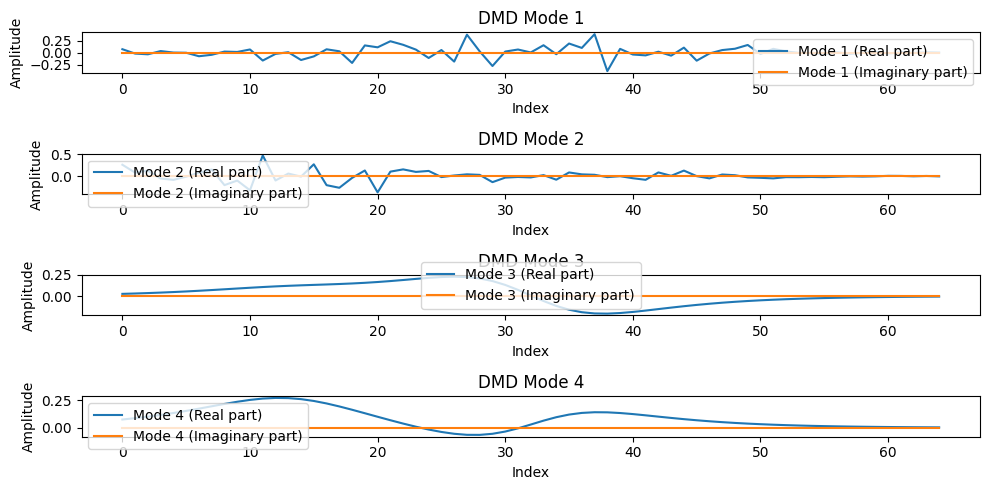

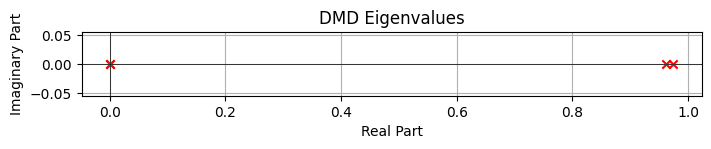

<ipython-input-6-bd91d7b65133>:124: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(omega)), np.abs(omega), use_line_collection=True)


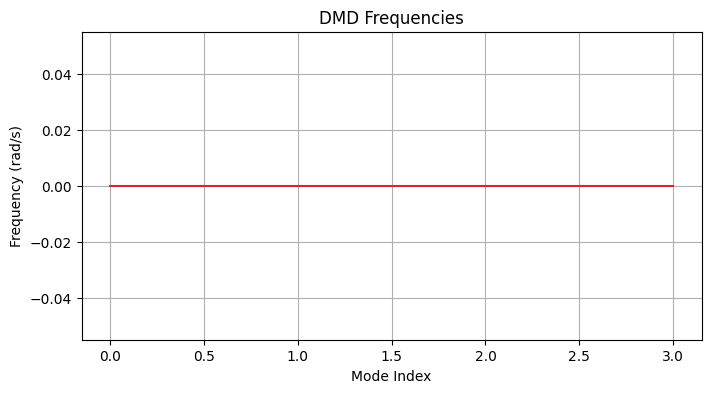

In [ ]:
# Example 3
if __name__ == "__main__":
    # Generate some example data
    t = t_data
    X1 = X[0:-1, :].T  # Example data
    X2 = X[1:, :].T  # Shifted data

    # Apply DMD
    Phi, Lambda, omega = dynamic_mode_decomposition(X1, X2, r=4)

    print("DMD Modes:\n", Phi)
    print("DMD Eigenvalues:\n", Lambda)
    print("DMD Frequencies:\n", omega)

    # Plot results
    plot_dmd_results(Phi, Lambda, omega)

In [ ]:
import numpy as np
from scipy.integrate import odeint
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import itertools

def plot_ode_trajectories_with_arrows_and_save(mu_values, lambda_values, dt=0.001, t_max=10, x0_train=[2, 4], arrow_step=50, filename="plot.html"):
    """
    Creates an interactive 3D plot of the ODE system for multiple values of mu and lambda with different colors and arrows indicating the direction.
    Saves the plot as an HTML file.

    Parameters:
    mu_values (list of floats): List of mu values to simulate.
    lambda_values (list of floats): List of lambda values to simulate.
    dt (float): Time step for the simulation.
    t_max (float): Maximum time value for the simulation.
    x0_train (list of floats): Initial conditions for the ODE system.
    arrow_step (int): Step size for placing arrows on the trajectory to indicate direction.
    filename (str): The name of the HTML file to save the plot.
    """

    # Time vector
    t_train = np.arange(0, t_max, dt)

    # Initialize the plot
    fig = go.Figure()

    # Generate a list of colors for the trajectories using a colormap
    num_trajectories = len(mu_values) * len(lambda_values)
    colors = plt.cm.jet(np.linspace(0, 1, num_trajectories))

    # Iterate over all combinations of mu and lambda
    for (mu, lam), color in zip(itertools.product(mu_values, lambda_values), colors):
        # Define the system of ODEs
        def ode(x, t):
            return [
                mu * x[0],
                lam * (x[1] - x[0] ** 2)
            ]

        # Solve the system
        X = odeint(ode, x0_train, t_train)

        # Extract components
        x1 = X[:, 0]
        x2 = X[:, 1]
        t = t_train

        # Add the trajectory to the plot with a unique color and smaller markers
        fig.add_trace(go.Scatter3d(
            x=t, y=x1, z=x2,
            mode='lines+markers',
            line=dict(color=f'rgba({color[0]*255}, {color[1]*255}, {color[2]*255}, 1)', width=3),
            marker=dict(size=2),  # Smaller markers
            name=f'μ={mu}, λ={lam}'
        ))

        # Add arrows to indicate the direction of the trajectory
        for i in range(0, len(t)-arrow_step, arrow_step):
            fig.add_trace(go.Cone(
                x=[t[i]], y=[x1[i]], z=[x2[i]],
                u=[t[i+1] - t[i]],
                v=[x1[i+1] - x1[i]],
                w=[x2[i+1] - x2[i]],
                colorscale=[[0, f'rgba({color[0]*255}, {color[1]*255}, {color[2]*255}, 1)'], [1, f'rgba({color[0]*255}, {color[1]*255}, {color[2]*255}, 1)']],
                showscale=False,
                sizemode="absolute",
                sizeref=0.2  # Adjust arrow size
            ))

    # Update plot layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Time',
            yaxis_title='x1',
            zaxis_title='x2'
        ),
        title='3D Trajectories of the ODE System with Arrows Indicating Direction',
        legend_title_text='Trajectories',
        autosize=True
    )

    # Save the plot as an HTML file
    fig.write_html(filename)
    print(f"Plot saved as {filename}")

# Example usage with multiple values of mu and lambda
mu_values = [-1, -0.5, -0.1]
lambda_values = [-10, -5, -1]

plot_ode_trajectories_with_arrows_and_save(mu_values, lambda_values, filename="trajectory_plot.html")


Plot saved as trajectory_plot.html


In [ ]:
# Koopman mode for given dynamical system
!pip install pykoopman
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

import pykoopman as pk